# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import tarfile
import urllib

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Gather

First, the data is loaded into the notebook. I also looked at the two Excel documents (./DIAS Information Levels - Attributes 2017.xlsx and (./DIAS Attributes - Values 2017.xlsx) to get an idea of the data that was in the datasets.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias= azdias.sample(191652)

In [3]:
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
attributes_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)

Looking  at how many rows and columns are in the datasets and Excel files

In [5]:
print(azdias.shape)
print(customers.shape)
print(attributes_values.shape)
print(attributes_info.shape)

(191652, 366)
(191652, 369)
(2258, 4)
(313, 4)


To make sure the data has loaded correctly, I checked the heads of each dataset.

In [6]:
# check the head of azdias data
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
886199,192665,-1,5.0,19.0,NaN,NaN,NaN,NaN,19.0,40.0,...,4.0,4.0,7.0,5.0,6.0,4.0,4.0,5,2,1
47902,885790,2,1.0,19.0,NaN,NaN,NaN,NaN,12.0,NaN,...,NaN,3.0,5.0,3.0,2.0,9.0,NaN,3,2,4
578241,293756,1,1.0,12.0,NaN,NaN,NaN,NaN,12.0,1.0,...,1.0,6.0,6.0,3.0,6.0,9.0,0.0,3,1,4
283894,690420,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2,3
862418,359195,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,6.0,...,3.0,8.0,8.0,5.0,6.0,9.0,3.0,3,1,4


In [7]:
# check the head of customer data
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


I also check the Excel files

In [8]:
# check the head of attributes values
attributes_values.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


In [9]:
# check the head of attributes information levels
attributes_info.head()

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


### Assess

Now the data is loaded, I need to assess the data to decide how to clean it and prepare it for the model I will develop. First, I had a look at the types of each column. 

In [10]:
azdias.dtypes

LNR                             int64
AGER_TYP                        int64
AKT_DAT_KL                    float64
ALTER_HH                      float64
ALTER_KIND1                   float64
ALTER_KIND2                   float64
ALTER_KIND3                   float64
ALTER_KIND4                   float64
ALTERSKATEGORIE_FEIN          float64
ANZ_HAUSHALTE_AKTIV           float64
ANZ_HH_TITEL                  float64
ANZ_KINDER                    float64
ANZ_PERSONEN                  float64
ANZ_STATISTISCHE_HAUSHALTE    float64
ANZ_TITEL                     float64
ARBEIT                        float64
BALLRAUM                      float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                object
CAMEO_INTL_2015                object
CJT_GESAMTTYP                 float64
CJT_KATALOGNUTZER             float64
CJT_TYP_1                     float64
CJT_TYP_2                     float64
CJT_TYP_3                     float64
CJT_TYP_4                     float64
CJT_TYP_5   

In [11]:
customers.dtypes

LNR                             int64
AGER_TYP                        int64
AKT_DAT_KL                    float64
ALTER_HH                      float64
ALTER_KIND1                   float64
ALTER_KIND2                   float64
ALTER_KIND3                   float64
ALTER_KIND4                   float64
ALTERSKATEGORIE_FEIN          float64
ANZ_HAUSHALTE_AKTIV           float64
ANZ_HH_TITEL                  float64
ANZ_KINDER                    float64
ANZ_PERSONEN                  float64
ANZ_STATISTISCHE_HAUSHALTE    float64
ANZ_TITEL                     float64
ARBEIT                        float64
BALLRAUM                      float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                object
CAMEO_INTL_2015                object
CJT_GESAMTTYP                 float64
CJT_KATALOGNUTZER             float64
CJT_TYP_1                     float64
CJT_TYP_2                     float64
CJT_TYP_3                     float64
CJT_TYP_4                     float64
CJT_TYP_5   

From this, I can see that there are a mixture of object, float64 and int64. From looking at the DIAS Attributes - Values 2017 Excel file, there doesn't appear to be a reason why the values should be in floats as they are all integer values. However, I did notice that the CAMEO_DEU_2015 column has number and letter values in it so this would not be able to be an int64 type.

I decided to have a closer look at the object columns to see if there are any reasons why they are objects. These also include the columns that are mentioned in the warning when the data was loaded.

In [12]:
customers[customers.columns[customers.dtypes == 'object']]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER
5,5D,5,34,D19_BUCH_CD,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
6,3B,3,23,D19_DROGERIEARTIKEL,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
7,1D,1,15,D19_SONSTIGE,1992-02-10 00:00:00,W,FOOD,SINGLE_BUYER
8,9E,9,55,D19_SONSTIGE,2004-10-14 00:00:00,W,COSMETIC,MULTI_BUYER
9,1D,1,15,D19_BUCH_CD,1997-07-14 00:00:00,W,COSMETIC,MULTI_BUYER


Most of the columns are strings so it is understandable that they would be object types. However, the CAMEO_DEUG_2015 and CAMEO_INTL_2015 columns appear to have just numbers so those columns should probably be integer or float types.

I then looked at how many NaN values were in the datasets by counting how many were in each column.

In [13]:
azdias.isnull().sum()

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     15883
ALTER_HH                       15883
ALTER_KIND1                   174369
ALTER_KIND2                   185315
ALTER_KIND3                   190345
ALTER_KIND4                   191383
ALTERSKATEGORIE_FEIN           56869
ANZ_HAUSHALTE_AKTIV            20094
ANZ_HH_TITEL                   20952
ANZ_KINDER                     15883
ANZ_PERSONEN                   15883
ANZ_STATISTISCHE_HAUSHALTE     20094
ANZ_TITEL                      15883
ARBEIT                         20929
BALLRAUM                       20229
CAMEO_DEU_2015                 21332
CAMEO_DEUG_2015                21332
CAMEO_INTL_2015                21332
CJT_GESAMTTYP                   1017
CJT_KATALOGNUTZER               1017
CJT_TYP_1                       1017
CJT_TYP_2                       1017
CJT_TYP_3                       1017
CJT_TYP_4                       1017
CJT_TYP_5                       1017
C

In [14]:
customers.isnull().sum()

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     46596
ALTER_HH                       46596
ALTER_KIND1                   179886
ALTER_KIND2                   186552
ALTER_KIND3                   190377
ALTER_KIND4                   191416
ALTERSKATEGORIE_FEIN           51842
ANZ_HAUSHALTE_AKTIV            49927
ANZ_HH_TITEL                   52110
ANZ_KINDER                     46596
ANZ_PERSONEN                   46596
ANZ_STATISTISCHE_HAUSHALTE     49927
ANZ_TITEL                      46596
ARBEIT                         50476
BALLRAUM                       49959
CAMEO_DEU_2015                 50428
CAMEO_DEUG_2015                50428
CAMEO_INTL_2015                50428
CJT_GESAMTTYP                   3213
CJT_KATALOGNUTZER               3213
CJT_TYP_1                       3213
CJT_TYP_2                       3213
CJT_TYP_3                       3213
CJT_TYP_4                       3213
CJT_TYP_5                       3213
C

From this, I can see that there are some columns with the majority of values missing. I decided to have a closer look at the ALTER_KIND columns as these appeared to have the vast majority of data missing and the description of what was in these columns was not in the Excel files.

In [15]:
azdias['ALTER_KIND1'].value_counts()

18.0    1395
7.0     1349
17.0    1337
8.0     1327
16.0    1317
14.0    1273
9.0     1265
15.0    1244
10.0    1220
12.0    1210
13.0    1201
11.0    1171
6.0     1080
5.0      325
3.0      234
4.0      233
2.0      102
Name: ALTER_KIND1, dtype: int64

I discovered that alter kind means child's age in English. Therefore, these columns were the ages of the children living in the household. This explained why there were missing values in these columns, as not everybody would have a child living with them.

Then I decided to looking at the counts of the values in each column to find out how many -1, 9 and 0 were in each column of the datasets, this would help me to decide on what I should do with these values in my analysis. However, I found that the datasets were too large to do this in one go and the kernel kept dying. I looked at the column names.

In [16]:
print(azdias.columns.values)

['LNR' 'AGER_TYP' 'AKT_DAT_KL' 'ALTER_HH' 'ALTER_KIND1' 'ALTER_KIND2'
 'ALTER_KIND3' 'ALTER_KIND4' 'ALTERSKATEGORIE_FEIN' 'ANZ_HAUSHALTE_AKTIV'
 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_PERSONEN' 'ANZ_STATISTISCHE_HAUSHALTE'
 'ANZ_TITEL' 'ARBEIT' 'BALLRAUM' 'CAMEO_DEU_2015' 'CAMEO_DEUG_2015'
 'CAMEO_INTL_2015' 'CJT_GESAMTTYP' 'CJT_KATALOGNUTZER' 'CJT_TYP_1'
 'CJT_TYP_2' 'CJT_TYP_3' 'CJT_TYP_4' 'CJT_TYP_5' 'CJT_TYP_6'
 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24' 'D19_BANKEN_DATUM'
 'D19_BANKEN_DIREKT' 'D19_BANKEN_GROSS' 'D19_BANKEN_LOKAL'
 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_BANKEN_REST' 'D19_BEKLEIDUNG_GEH'
 'D19_BEKLEIDUNG_REST' 'D19_BILDUNG' 'D19_BIO_OEKO' 'D19_BUCH_CD'
 'D19_DIGIT_SERV' 'D19_DROGERIEARTIKEL' 'D19_ENERGIE' 'D19_FREIZEIT'
 'D19_GARTEN' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24' 'D19_GESAMT_DATUM'
 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM'
 'D19_GESAMT_ONLINE_QUOTE_12' 'D19_HANDWERK' 'D19_HAUS_DEKO'
 'D19_KINDERARTIKEL' '

In [17]:
print(azdias.columns.values)

['LNR' 'AGER_TYP' 'AKT_DAT_KL' 'ALTER_HH' 'ALTER_KIND1' 'ALTER_KIND2'
 'ALTER_KIND3' 'ALTER_KIND4' 'ALTERSKATEGORIE_FEIN' 'ANZ_HAUSHALTE_AKTIV'
 'ANZ_HH_TITEL' 'ANZ_KINDER' 'ANZ_PERSONEN' 'ANZ_STATISTISCHE_HAUSHALTE'
 'ANZ_TITEL' 'ARBEIT' 'BALLRAUM' 'CAMEO_DEU_2015' 'CAMEO_DEUG_2015'
 'CAMEO_INTL_2015' 'CJT_GESAMTTYP' 'CJT_KATALOGNUTZER' 'CJT_TYP_1'
 'CJT_TYP_2' 'CJT_TYP_3' 'CJT_TYP_4' 'CJT_TYP_5' 'CJT_TYP_6'
 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24' 'D19_BANKEN_DATUM'
 'D19_BANKEN_DIREKT' 'D19_BANKEN_GROSS' 'D19_BANKEN_LOKAL'
 'D19_BANKEN_OFFLINE_DATUM' 'D19_BANKEN_ONLINE_DATUM'
 'D19_BANKEN_ONLINE_QUOTE_12' 'D19_BANKEN_REST' 'D19_BEKLEIDUNG_GEH'
 'D19_BEKLEIDUNG_REST' 'D19_BILDUNG' 'D19_BIO_OEKO' 'D19_BUCH_CD'
 'D19_DIGIT_SERV' 'D19_DROGERIEARTIKEL' 'D19_ENERGIE' 'D19_FREIZEIT'
 'D19_GARTEN' 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24' 'D19_GESAMT_DATUM'
 'D19_GESAMT_OFFLINE_DATUM' 'D19_GESAMT_ONLINE_DATUM'
 'D19_GESAMT_ONLINE_QUOTE_12' 'D19_HANDWERK' 'D19_HAUS_DEKO'
 'D19_KINDERARTIKEL' '

I realised that exploring the dataframe as a whole is inefficient as it is so large. Therefore, to explore in in more detail, I decided to break it up into smaller dataframes based on the information levels in the DIAS Information Levels - Attributes 2017 file. This way, I could look at each level in turn and dig deeper into the values held in the datasets. 

In [18]:
# creating a new dataframe of the 'person' columns in the azdias dataframe
person_azdias=azdias[['LNR', 'AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
                  'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 
                  'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 
                  'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
                  'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                  'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 
                  'SEMIO_DOM', 'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT',
                  'SEMIO_LUST', 'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 
                  'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
                  'VERS_TYP', 'ZABEOTYP']]


When completing this dataframe, I found that SOHO_FLAG, which was in the Excel files, was not in the dataframe column names. I have made the assumption that SOHO_FLAG is SOHO_KZ.

In [19]:
person_azdias.head()

,LNR,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP
886199,192665,-1,1,2,3.0,1,4,1,4,4,...,7,5,2,6,2,2,0.0,0.0,2,5
47902,885790,2,4,2,6.0,5,1,5,2,3,...,4,4,2,1,4,1,0.0,0.0,1,3
578241,293756,1,4,1,3.0,5,1,5,2,2,...,1,2,3,1,7,3,0.0,0.0,1,3
283894,690420,-1,3,2,6.0,3,4,3,5,5,...,4,7,2,3,1,-1,NaN,NaN,-1,3
862418,359195,2,4,1,1.0,4,1,5,1,1,...,1,3,6,2,7,2,0.0,0.0,2,3


In [20]:
# creating a new household dataframe with the columns from the dataframe
household_azdias=azdias[['ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
                  'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
                  'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
                  'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
                  'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 
                  'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
                  'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
                  'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
                  'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
                  'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
                  'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
                  'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK',
                  'D19_LEBENSMITTEL', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO',
                  'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL',
                  'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK',
                  'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE',
                  'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
                  'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
                  'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
                  'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
                  'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSAND_REST', 'D19_VERSI_ANZ_12',
                  'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
                  'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSICHERUNGEN',
                  'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
                  'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
                  'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP']]


I found that 'HAUSHALTSSTRUKTUR' was not in the dataframe so I excluded it. I also found that the FINANZ_ names were in the dataframe but not in the Excel files. As finanz is financial in English, I assumed these belonged in the household category. In addition to this, I included all the D19_ columns as they were all transactional data.

In [21]:
household_azdias.head()

,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,D19_WEIN_FEINKOST,W_KEIT_KIND_HH,WOHNDAUER_2008,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP
886199,19.0,NaN,NaN,NaN,NaN,1.0,0.0,6.0,0,0,...,0,6.0,4.0,4,5,1,4,4,1,4
47902,19.0,NaN,NaN,NaN,NaN,4.0,0.0,NaN,0,0,...,0,2.0,9.0,2,3,5,1,3,5,2
578241,12.0,NaN,NaN,NaN,NaN,1.0,0.0,3.0,0,0,...,0,6.0,9.0,2,2,5,1,2,5,2
283894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,0,...,0,NaN,NaN,5,3,3,4,5,3,4
862418,9.0,NaN,NaN,NaN,NaN,1.0,0.0,5.0,0,0,...,0,6.0,9.0,1,5,4,1,1,5,6


In [22]:
# creating a building dataframe from the dataframe
building_azdias=azdias[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KBA05_HERSTTEMP', 
                        'KBA05_MODTEMP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 
                        'WOHNLAGE']]


I found that 'GEOSCORE_KLS7' was not in the dataframe so I decided to exclude it.

In [23]:
building_azdias.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KBA05_HERSTTEMP,KBA05_MODTEMP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE
886199,40.0,1.0,3.0,3.0,1.0,2.0,1994.0,O,4.0
47902,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
578241,1.0,0.0,1.0,5.0,5.0,3.0,1999.0,O,0.0
283894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862418,6.0,0.0,1.0,3.0,4.0,4.0,1993.0,O,3.0


In [24]:
# create a status dataframe from dataframe
status_azdias=azdias[['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']]

In [25]:
status_azdias.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015
886199,9D,9,51
47902,NaN,NaN,NaN
578241,7A,7,41
283894,NaN,NaN,NaN
862418,8C,8,54


In [26]:
# create a share of dataframefrom the dataframe
share_azdias=azdias[['KBA05_ALTER2',
 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2',
 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1',
 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU',
 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4',
 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER',
 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3',
 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG',
 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4',
 'KBA05_MOD8', 'KBA05_MODTEMP', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1',
 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5',
 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB0',
 'KBA05_VORB1', 'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL3',
 'KBA05_ZUL4', 'KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45',
 'KBA13_ALTERHALTER_60', 'KBA13_ALTERHALTER_61', 'KBA13_ANTG1', 'KBA13_ANTG2',
 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_ANZAHL_PKW', 'KBA13_AUDI',
 'KBA13_AUTOQUOTE', 'KBA13_BAUMAX', 'KBA13_BJ_1999', 'KBA13_BJ_2000',
 'KBA13_BJ_2004', 'KBA13_BJ_2006', 'KBA13_BJ_2008', 'KBA13_BJ_2009',
 'KBA13_BMW', 'KBA13_CCM_0_1400', 'KBA13_CCM_1000', 'KBA13_CCM_1200',
 'KBA13_CCM_1400', 'KBA13_CCM_1401_2500', 'KBA13_CCM_1500', 'KBA13_CCM_1600',
 'KBA13_CCM_1800', 'KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_CCM_2501',
 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_FAB_ASIEN', 'KBA13_FAB_SONSTIGE',
 'KBA13_FIAT', 'KBA13_FORD', 'KBA13_GBZ', 'KBA13_HALTER_20', 'KBA13_HALTER_25',
 'KBA13_HALTER_30', 'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45',
 'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60', 'KBA13_HALTER_65',
 'KBA13_HALTER_66', 'KBA13_HERST_ASIEN', 'KBA13_HERST_AUDI_VW',
 'KBA13_HERST_BMW_BENZ', 'KBA13_HERST_EUROPA', 'KBA13_HERST_FORD_OPEL',
 'KBA13_HERST_SONST', 'KBA13_HHZ', 'KBA13_KMH_0_140', 'KBA13_KMH_110',
 'KBA13_KMH_140', 'KBA13_KMH_140_210', 'KBA13_KMH_180', 'KBA13_KMH_210',
 'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KMH_251', 'KBA13_KRSAQUOT',
 'KBA13_KRSHERST_AUDI_VW', 'KBA13_KRSHERST_BMW_BENZ',
 'KBA13_KRSHERST_FORD_OPEL', 'KBA13_KRSSEG_KLEIN', 'KBA13_KRSSEG_OBER',
 'KBA13_KRSSEG_VAN', 'KBA13_KRSZUL_NEU', 'KBA13_KW_0_60', 'KBA13_KW_110',
 'KBA13_KW_120', 'KBA13_KW_121', 'KBA13_KW_30', 'KBA13_KW_40', 'KBA13_KW_50',
 'KBA13_KW_60', 'KBA13_KW_61_120', 'KBA13_KW_70', 'KBA13_KW_80', 'KBA13_KW_90',
 'KBA13_MAZDA', 'KBA13_MERCEDES', 'KBA13_MOTOR', 'KBA13_NISSAN', 'KBA13_OPEL',
 'KBA13_PEUGEOT', 'KBA13_RENAULT', 'KBA13_SEG_GELAENDEWAGEN',
 'KBA13_SEG_GROSSRAUMVANS', 'KBA13_SEG_KLEINST', 'KBA13_SEG_KLEINWAGEN',
 'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_SEG_MINIVANS', 'KBA13_SEG_MINIWAGEN',
 'KBA13_SEG_MITTELKLASSE', 'KBA13_SEG_OBEREMITTELKLASSE',
 'KBA13_SEG_OBERKLASSE', 'KBA13_SEG_SONSTIGE', 'KBA13_SEG_SPORTWAGEN',
 'KBA13_SEG_UTILITIES', 'KBA13_SEG_VAN', 'KBA13_SEG_WOHNMOBILE',
 'KBA13_SITZE_4', 'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_TOYOTA',
 'KBA13_VORB_0', 'KBA13_VORB_1', 'KBA13_VORB_1_2', 'KBA13_VORB_2',
 'KBA13_VORB_3', 'KBA13_VW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3',
 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ']]



WACHSTUMSGEBIET_NB was in the Excel file but not in the dataframe so I excluded it.

In [27]:
share_azdias.head()

,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,...,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ
886199,5.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,...,3.0,5.0,3.0,1.0,0.0,3.0,2.0,5.0,1.0,3.0
47902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
578241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862418,3.0,2.0,4.0,1.0,2.0,3.0,0.0,0.0,3.0,0.0,...,1.0,2.0,1.0,2.0,4.0,2.0,0.0,2.0,3.0,3.0


In [28]:
# create postcode dataframe from dataframe
postcode_azdias=azdias[['BALLRAUM', 'EWDICHTE', 'INNENSTADT']]

In [29]:
postcode_azdias.head()

,BALLRAUM,EWDICHTE,INNENSTADT
886199,1.0,6.0,2.0
47902,NaN,NaN,NaN
578241,5.0,1.0,7.0
283894,NaN,NaN,NaN
862418,6.0,4.0,1.0


In [30]:
# creating a RR1 dataframe from the dataframe
rr1_azdias=azdias[['GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP']]

In [31]:
rr1_azdias.head()

,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP
886199,4.0,3.0,1.0,4.0,7.0
47902,NaN,NaN,NaN,3.0,NaN
578241,3.0,3.0,NaN,4.0,5.0
283894,NaN,NaN,NaN,2.0,NaN
862418,4.0,4.0,3.0,2.0,6.0


In [32]:
# create a community dataframe from the dateframe
community_azdias=azdias[['ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']]

EINWOHNER was in the Excel file but not in the dataframe so I excluded it.

In [33]:
community_azdias.head()

,ARBEIT,ORTSGR_KLS9,RELAT_AB
886199,4.0,9.0,3.0
47902,NaN,NaN,NaN
578241,5.0,4.0,5.0
283894,NaN,NaN,NaN
862418,5.0,6.0,5.0


Now the azdias dataframe was split into seperate dataframes, I did the same thing for the customer dataframe.

In [34]:
# creating a person dataframe from customer dataframe
person_customers=customers[['LNR', 'AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
                  'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 
                  'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 
                  'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
                  'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                  'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 
                  'SEMIO_DOM', 'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT',
                  'SEMIO_LUST', 'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 
                  'SEMIO_SOZ', 'SEMIO_TRADV', 'SEMIO_VERT', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
                  'VERS_TYP', 'ZABEOTYP']]


In [35]:
person_customers.head()

,LNR,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP
0,9626,2,4,1,5.0,5,1,5,1,2,...,1,2,6,1,6,3,0.0,0.0,1,3
1,9628,-1,4,1,NaN,5,1,5,1,3,...,1,2,3,1,7,3,0.0,0.0,1,3
2,143872,-1,4,2,2.0,5,1,5,1,4,...,2,1,2,1,3,1,0.0,0.0,2,3
3,143873,1,4,1,2.0,5,1,5,2,1,...,3,3,6,4,7,0,0.0,0.0,1,1
4,143874,-1,3,1,6.0,3,1,4,4,5,...,5,4,4,4,5,1,0.0,0.0,2,1


In [36]:
# creating a new household dataframe with the columns from the dataframe
household_customers=customers[['ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
                  'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
                  'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
                  'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
                  'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 
                  'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
                  'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
                  'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
                  'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
                  'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
                  'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
                  'D19_KINDERARTIKEL', 'D19_KONSUMTYP', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK',
                  'D19_LEBENSMITTEL', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO',
                  'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL',
                  'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK',
                  'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE',
                  'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
                  'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
                  'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
                  'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
                  'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSAND_REST', 'D19_VERSI_ANZ_12',
                  'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
                  'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSICHERUNGEN',
                  'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
                  'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
                  'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP']]

In [37]:
household_customers.head()

,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,D19_WEIN_FEINKOST,W_KEIT_KIND_HH,WOHNDAUER_2008,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP
0,10.0,NaN,NaN,NaN,NaN,2.0,0.0,1.0,0,0,...,0,6.0,9.0,1,2,5,1,2,5,2
1,11.0,NaN,NaN,NaN,NaN,3.0,0.0,NaN,0,1,...,0,0.0,9.0,1,2,5,1,3,5,2
2,6.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0,0,...,0,6.0,9.0,1,4,5,1,4,5,2
3,8.0,NaN,NaN,NaN,NaN,0.0,0.0,4.0,0,0,...,0,NaN,9.0,2,2,5,1,1,5,6
4,20.0,NaN,NaN,NaN,NaN,4.0,0.0,6.0,1,2,...,0,2.0,9.0,4,2,3,1,5,4,2


In [38]:
# creating a building dataframe from the dataframe
building_customers=customers[['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KBA05_HERSTTEMP', 
                        'KBA05_MODTEMP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 
                        'WOHNLAGE']]

In [39]:
building_customers.head()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KBA05_HERSTTEMP,KBA05_MODTEMP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE
0,1.0,0.0,1.0,2.0,2.0,5.0,1992.0,W,7.0
1,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
2,1.0,0.0,8.0,2.0,3.0,1.0,1992.0,W,2.0
3,0.0,NaN,2.0,3.0,4.0,2.0,1992.0,W,7.0
4,7.0,0.0,3.0,1.0,4.0,1.0,1992.0,W,3.0


In [40]:
# create a status dataframe from dataframe
status_customers=customers[['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']]

In [41]:
status_customers.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,1A,1,13
1,NaN,NaN,NaN
2,5D,5,34
3,4C,4,24
4,7B,7,41


In [42]:
# create a share of dataframefrom the dataframe
share_customers=customers[['KBA05_ALTER2',
 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2',
 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1',
 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU',
 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4',
 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1',
 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER',
 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3',
 'KBA05_MAXAH', 'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG',
 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4',
 'KBA05_MOD8', 'KBA05_MODTEMP', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1',
 'KBA05_SEG10', 'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5',
 'KBA05_SEG6', 'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VORB0',
 'KBA05_VORB1', 'KBA05_VORB2', 'KBA05_ZUL1', 'KBA05_ZUL2', 'KBA05_ZUL3',
 'KBA05_ZUL4', 'KBA13_ALTERHALTER_30', 'KBA13_ALTERHALTER_45',
 'KBA13_ALTERHALTER_60', 'KBA13_ALTERHALTER_61', 'KBA13_ANTG1', 'KBA13_ANTG2',
 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_ANZAHL_PKW', 'KBA13_AUDI',
 'KBA13_AUTOQUOTE', 'KBA13_BAUMAX', 'KBA13_BJ_1999', 'KBA13_BJ_2000',
 'KBA13_BJ_2004', 'KBA13_BJ_2006', 'KBA13_BJ_2008', 'KBA13_BJ_2009',
 'KBA13_BMW', 'KBA13_CCM_0_1400', 'KBA13_CCM_1000', 'KBA13_CCM_1200',
 'KBA13_CCM_1400', 'KBA13_CCM_1401_2500', 'KBA13_CCM_1500', 'KBA13_CCM_1600',
 'KBA13_CCM_1800', 'KBA13_CCM_2000', 'KBA13_CCM_2500', 'KBA13_CCM_2501',
 'KBA13_CCM_3000', 'KBA13_CCM_3001', 'KBA13_FAB_ASIEN', 'KBA13_FAB_SONSTIGE',
 'KBA13_FIAT', 'KBA13_FORD', 'KBA13_GBZ', 'KBA13_HALTER_20', 'KBA13_HALTER_25',
 'KBA13_HALTER_30', 'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45',
 'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60', 'KBA13_HALTER_65',
 'KBA13_HALTER_66', 'KBA13_HERST_ASIEN', 'KBA13_HERST_AUDI_VW',
 'KBA13_HERST_BMW_BENZ', 'KBA13_HERST_EUROPA', 'KBA13_HERST_FORD_OPEL',
 'KBA13_HERST_SONST', 'KBA13_HHZ', 'KBA13_KMH_0_140', 'KBA13_KMH_110',
 'KBA13_KMH_140', 'KBA13_KMH_140_210', 'KBA13_KMH_180', 'KBA13_KMH_210',
 'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KMH_251', 'KBA13_KRSAQUOT',
 'KBA13_KRSHERST_AUDI_VW', 'KBA13_KRSHERST_BMW_BENZ',
 'KBA13_KRSHERST_FORD_OPEL', 'KBA13_KRSSEG_KLEIN', 'KBA13_KRSSEG_OBER',
 'KBA13_KRSSEG_VAN', 'KBA13_KRSZUL_NEU', 'KBA13_KW_0_60', 'KBA13_KW_110',
 'KBA13_KW_120', 'KBA13_KW_121', 'KBA13_KW_30', 'KBA13_KW_40', 'KBA13_KW_50',
 'KBA13_KW_60', 'KBA13_KW_61_120', 'KBA13_KW_70', 'KBA13_KW_80', 'KBA13_KW_90',
 'KBA13_MAZDA', 'KBA13_MERCEDES', 'KBA13_MOTOR', 'KBA13_NISSAN', 'KBA13_OPEL',
 'KBA13_PEUGEOT', 'KBA13_RENAULT', 'KBA13_SEG_GELAENDEWAGEN',
 'KBA13_SEG_GROSSRAUMVANS', 'KBA13_SEG_KLEINST', 'KBA13_SEG_KLEINWAGEN',
 'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_SEG_MINIVANS', 'KBA13_SEG_MINIWAGEN',
 'KBA13_SEG_MITTELKLASSE', 'KBA13_SEG_OBEREMITTELKLASSE',
 'KBA13_SEG_OBERKLASSE', 'KBA13_SEG_SONSTIGE', 'KBA13_SEG_SPORTWAGEN',
 'KBA13_SEG_UTILITIES', 'KBA13_SEG_VAN', 'KBA13_SEG_WOHNMOBILE',
 'KBA13_SITZE_4', 'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_TOYOTA',
 'KBA13_VORB_0', 'KBA13_VORB_1', 'KBA13_VORB_1_2', 'KBA13_VORB_2',
 'KBA13_VORB_3', 'KBA13_VW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3',
 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ']]

In [43]:
# create postcode dataframe from dataframe
postcode_customers=customers[['BALLRAUM', 'EWDICHTE', 'INNENSTADT']]

In [44]:
postcode_customers.head()

,BALLRAUM,EWDICHTE,INNENSTADT
0,3.0,2.0,4.0
1,NaN,NaN,NaN
2,7.0,4.0,1.0
3,7.0,1.0,7.0
4,3.0,4.0,4.0


In [45]:
# creating a RR1 dataframe from the dataframe
rr1_customers=customers[['GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP']]

In [46]:
rr1_customers.head()

,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP
0,4.0,1.0,4.0,3.0,1.0
1,NaN,NaN,NaN,NaN,NaN
2,3.0,3.0,3.0,1.0,7.0
3,4.0,3.0,4.0,2.0,6.0
4,3.0,4.0,3.0,5.0,7.0


In [47]:
# create a community dataframe from the dateframe
community_customers=customers[['ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']]

In [48]:
community_customers.head()

,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2.0,1.0
1,NaN,NaN,NaN
2,3.0,5.0,3.0
3,1.0,3.0,1.0
4,3.0,5.0,1.0


Now that the dataframes have been seperated, I can start to explore them more. I started with the person dataframe. I decided to create histograms for each of the columns so I could get an idea as to how the values were distributed.

<function matplotlib.pyplot.show(*args, **kw)>

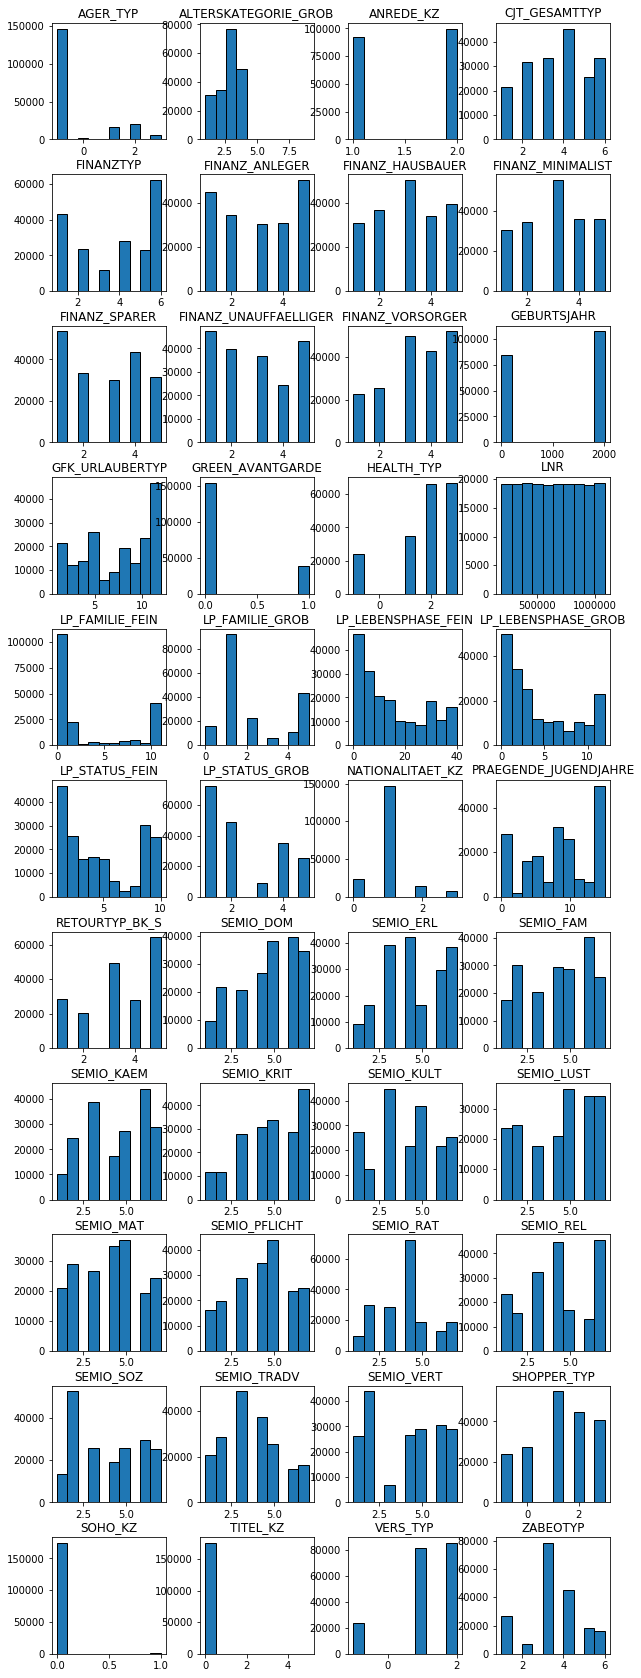

In [49]:
fig, axis = plt.subplots(11, 4, figsize=(10,30))
person_hist_azd=person_azdias.hist(ax=axis, edgecolor='black', grid=False)
plt.show

Looking at the histograms, AGER_TYP has a lot of -1 values which is 'unknown'. Therefore, I feel like this column would not contribute much to the model so I decided to drop it. The LNR is the person id so was expected to have a uniform distribution. The SOHO_KZ and TITEL_KZ have very little 1 values so, again, I decided to drop these as they wouldn't contribute much to the model.

<function matplotlib.pyplot.show(*args, **kw)>

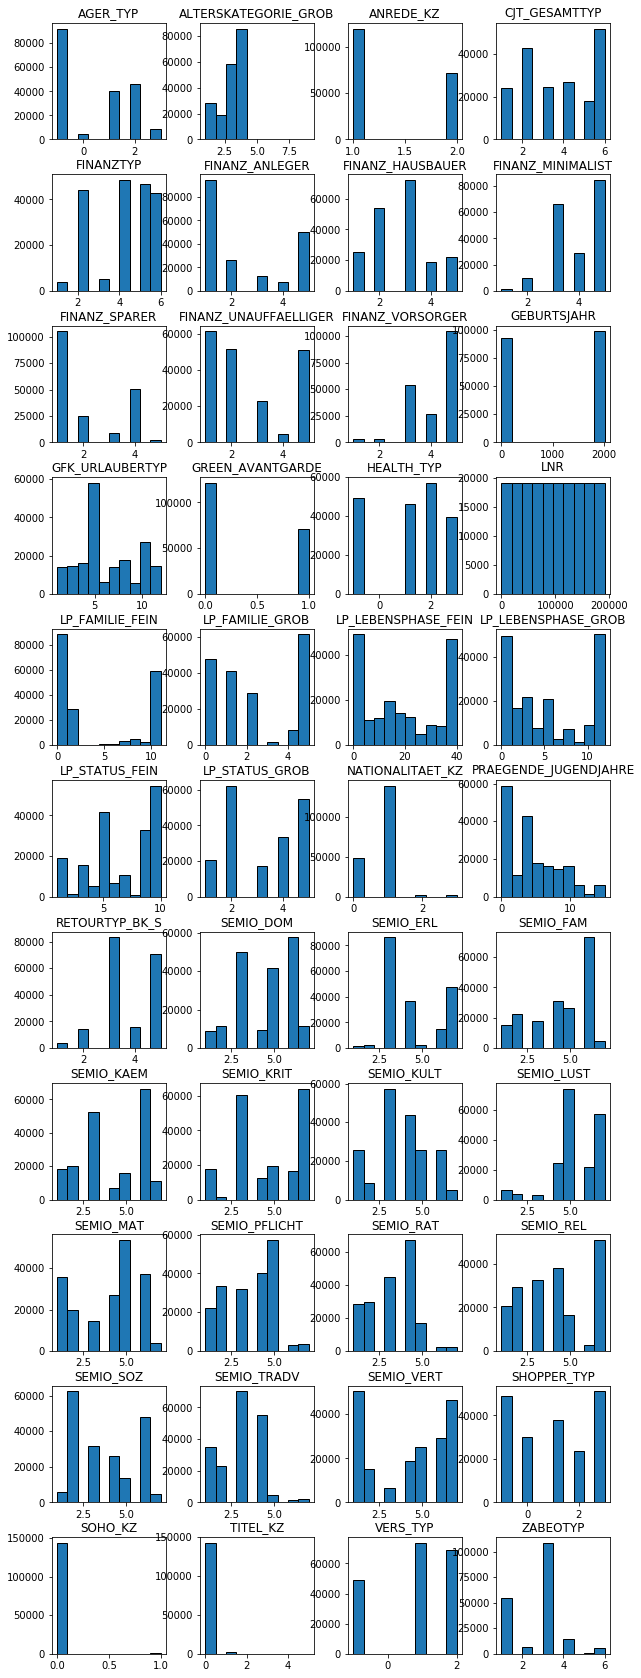

In [50]:
fig, axis = plt.subplots(11, 4, figsize=(10,30))
person_hist_cus=person_customers.hist(ax=axis, edgecolor='black', grid=False)
plt.show

Although the AGER_TYP in this dataframe has more of the other values than in the azdias dataframe, I still think it is best to drop it as it would not help when comparing the customers to the azdias customers. The SOHO_KZ and TITEL_KZ are very similar to the azdias data so I will definitely drop these columns too.

<function matplotlib.pyplot.show(*args, **kw)>

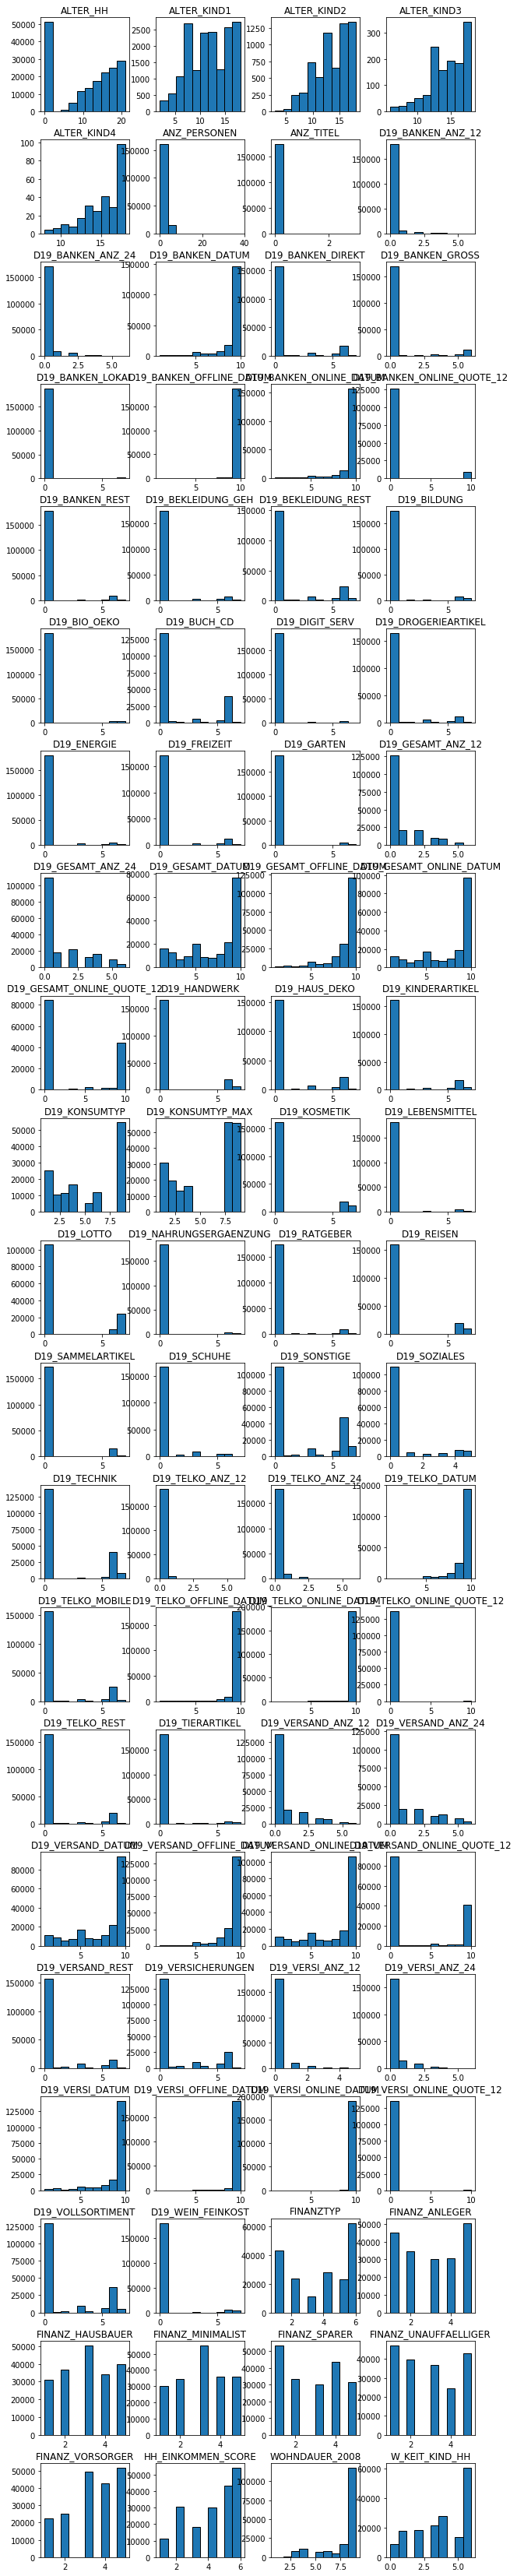

In [51]:
fig, axis = plt.subplots(21, 4, figsize=(10,60))
houshold_hist_azd=household_azdias.hist(ax=axis, edgecolor='black', grid=False)
plt.show

I have decided to drop quite a few of these columns as they have the majority of the same value so would not contribute a lot of value to the model. The columns I will keep for now are: ALTER_HH, ALTER_KIND1, ALTER_KIND2, ALTER_KIND3, ALTER_KIND4, D19_KONSUMTYP, D19_KONSUMTYP_MAX, FINANZTYP, FINANZ_ANLEGER, FINANZ_HAUSBAUER, FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_UFFAELLIGER, FINANZ_VORSORGER, HH_EINKOMMEN_SCORE, and W_KIET_KIND_HH.

<function matplotlib.pyplot.show(*args, **kw)>

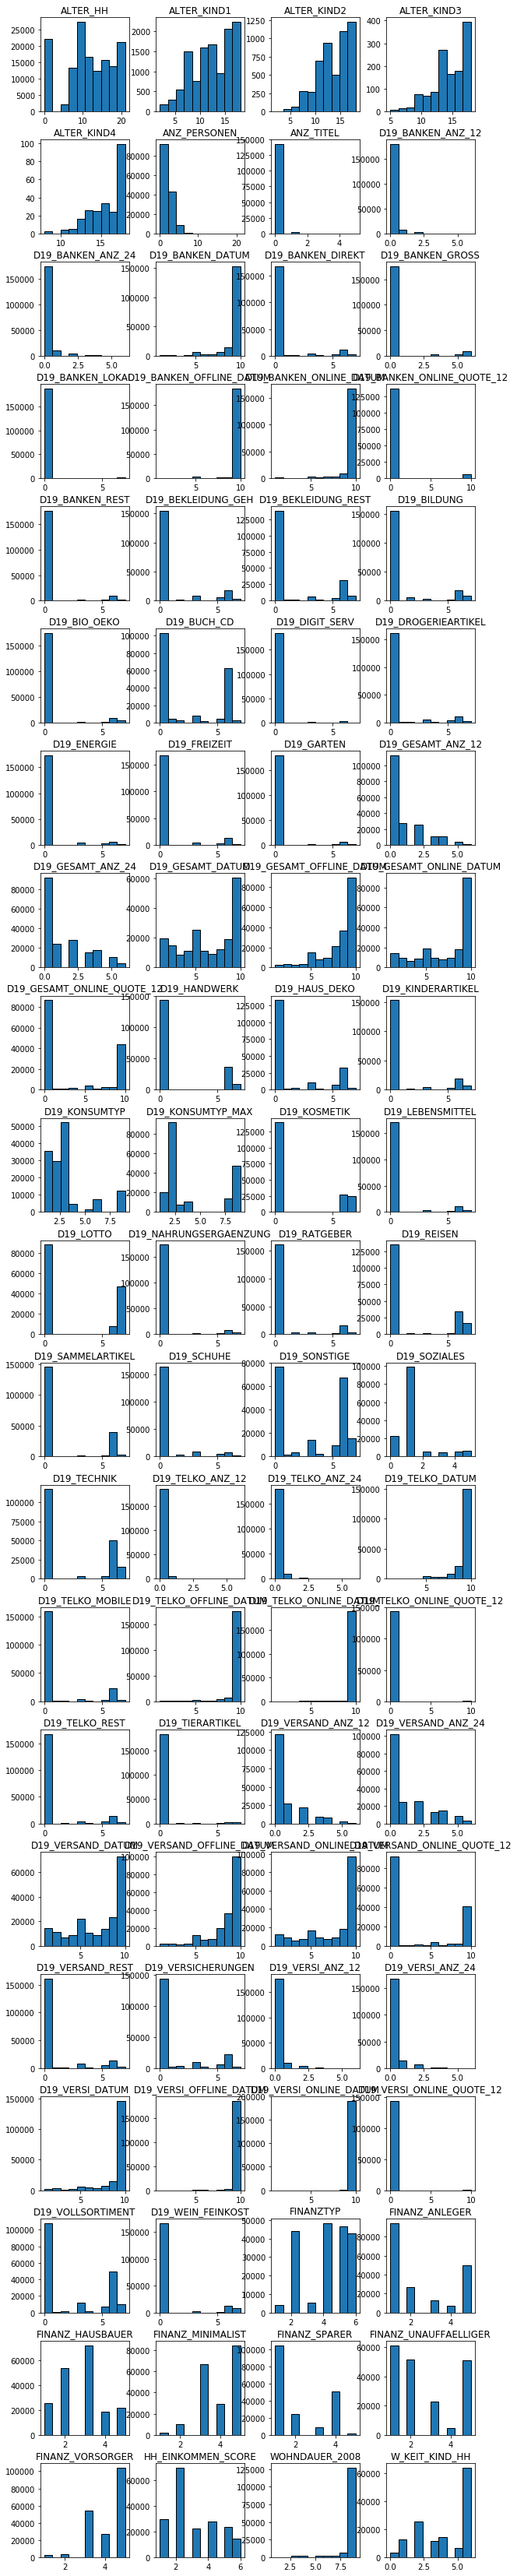

In [52]:
fig, axis = plt.subplots(21, 4, figsize=(10,60))
household_hist_cus=household_customers.hist(ax=axis, edgecolor='black', grid=False)
plt.show

Most of these histograms show similar to the azdias ones. There are a couple that have a better distribution of values but it wouldn't be worth keeping them as the customers would not relate well to the ones in azdias data based on these values.

I realised that I would be repeating the same bit of code for each of the dataframes so I decided to create a function to create the histograms to make the process quicker.

In [53]:
def create_histogram(df):
    factors=[]
    df=df.select_dtypes(exclude=[np.object])
    length=len(df.columns)
    
    if (int(round(length/4))*4) == length:
        x=int(round(len(df.columns)/4))
        y=4
    else:                                      
        for i in range(1, length+1):
            if length % i == 0:
                factors.append(i)
        factors.sort()
        factors.remove(factors[0])
        y=int(factors[0])
        x=int(length/y)
    
    a=y*3
    b=x*3
    fig, axis = plt.subplots(x, y, figsize=(a,b))
    hist=df.hist(ax=axis, edgecolor='black', grid=False)
    return hist


I then used the new function I had just made to create the histograms from the rest of the dataframes

<function matplotlib.pyplot.show(*args, **kw)>

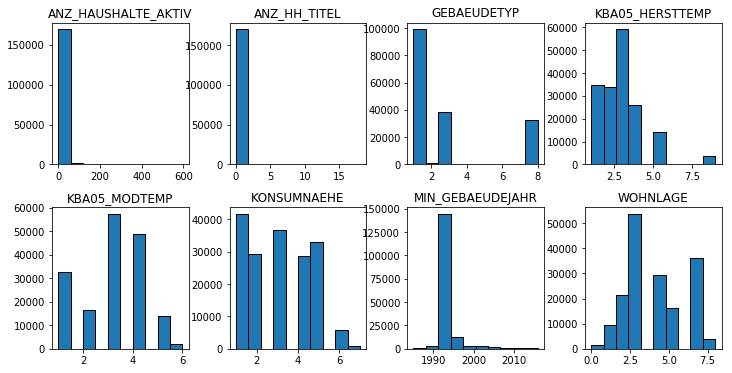

In [54]:
building_hist_azd=create_histogram(building_azdias)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

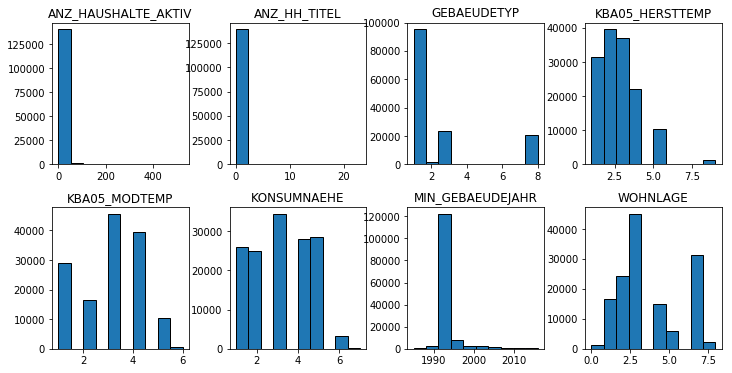

In [55]:
building_hist_cus=create_histogram(building_customers)
plt.show

From the histograms, I decided that I would drop ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL and MIN_GEBAEUDEJAHR columns as they would not contribute much to the model.

As the status dataframes contained object type columns, I decided to just look at the count of values to get an idea of the distribution of values.

In [56]:
status_azdias['CAMEO_DEU_2015'].value_counts()

6B    12132
8A    11210
4C    10195
3C     7534
2D     7511
3D     7416
7A     7398
8B     7254
4A     7148
8C     6685
9D     6121
9B     6062
9C     5320
7B     5213
9A     4300
2C     4193
8D     3822
6E     3428
2B     3233
6C     3202
5D     3153
2A     2942
5A     2617
1D     2523
1A     2312
3A     2277
5B     2252
5C     2187
7C     1985
4B     1979
4D     1788
3B     1533
6A     1469
9E     1374
6D     1268
6F     1205
7D     1189
4E     1149
1E     1084
7E      978
1B      944
5F      944
1C      943
5E      771
XX       77
Name: CAMEO_DEU_2015, dtype: int64

In [57]:
status_azdias['CAMEO_DEUG_2015'].value_counts()

8      16757
9      13343
6      13126
4      12905
8.0    12214
3      10875
2      10320
9.0     9834
7       9641
6.0     9578
4.0     9354
3.0     7885
2.0     7559
7.0     7122
5       6958
5.0     4966
1       4618
1.0     3188
X         77
Name: CAMEO_DEUG_2015, dtype: int64

In [58]:
status_azdias['CAMEO_INTL_2015'].value_counts()

51      16591
51.0    12122
24      11400
41      11394
41.0     8471
24.0     8117
14       7841
43       6959
14.0     5750
54       5702
43.0     5173
25       4977
54.0     4157
22       4051
25.0     3588
23       3352
45       3335
13       3253
22.0     3097
55       3010
52       2467
23.0     2437
31       2426
13.0     2292
45.0     2276
34       2269
55.0     2186
15       2134
44       1847
52.0     1833
12       1710
31.0     1660
34.0     1655
15.0     1473
44.0     1355
32       1335
35       1251
33       1239
12.0     1232
35.0      961
33.0      948
32.0      917
XX         77
Name: CAMEO_INTL_2015, dtype: int64

From looking at the values, I can see that some numbers are repeated, there is a float version and an integer version, eg. 54 and 54.0. Checking the Excel files shows me that these should be the same so I will have to change the columns to integers so this doesn't affect the way the numbers are interpreted. .

In [59]:
status_customers['CAMEO_DEU_2015'].value_counts()

2D    11208
6B     9634
4C     9053
3D     8085
4A     7507
3C     6628
1D     5880
2C     5076
5D     4546
8A     4252
1A     4198
7A     4109
8B     3790
2A     3715
2B     3485
7B     3421
1E     3337
6E     3086
6C     2832
8C     2801
1C     2206
8D     2206
4D     2124
4B     2093
5A     1969
9D     1957
3A     1904
3B     1773
5B     1696
5C     1574
9E     1508
4E     1287
6D     1235
7C     1194
6F     1168
1B     1157
5F     1059
7E     1034
9A     1023
9C      987
9B      917
5E      822
7D      800
6A      762
XX      126
Name: CAMEO_DEU_2015, dtype: int64

In [60]:
status_customers['CAMEO_DEUG_2015'].value_counts()

2      17574
4      16458
6      14008
3      13585
1      12498
8       9716
5       8624
7       7878
2.0     5910
4.0     5606
3.0     4805
9       4731
6.0     4709
1.0     4280
8.0     3333
5.0     3042
7.0     2680
9.0     1661
X        126
Name: CAMEO_DEUG_2015, dtype: int64

In [61]:
status_customers['CAMEO_INTL_2015'].value_counts()

14      14708
24      13301
41       8461
43       7158
25       6900
15       6845
51       5987
13       5728
22       5566
14.0     4939
24.0     4504
23       4276
34       3945
45       3936
54       3537
41.0     2859
55       2794
12       2791
43.0     2476
25.0     2472
15.0     2372
44       2144
51.0     2126
31       2050
13.0     1955
22.0     1941
35       1741
23.0     1494
34.0     1423
45.0     1352
54.0     1258
32       1256
33       1178
12.0      924
55.0      920
52        770
44.0      688
31.0      681
35.0      553
32.0      440
33.0      396
52.0      253
XX        126
Name: CAMEO_INTL_2015, dtype: int64

The values seem like they are well distributed with no clear value having the vast majority.
It is the same in the customers dataframe, with a mixture of integers and floats.

I was unable to use the create_histogram function for the share dataframes. As it is so large, the kernel kept dying. I decided to just type out the required code for these histograms.

<function matplotlib.pyplot.show(*args, **kw)>

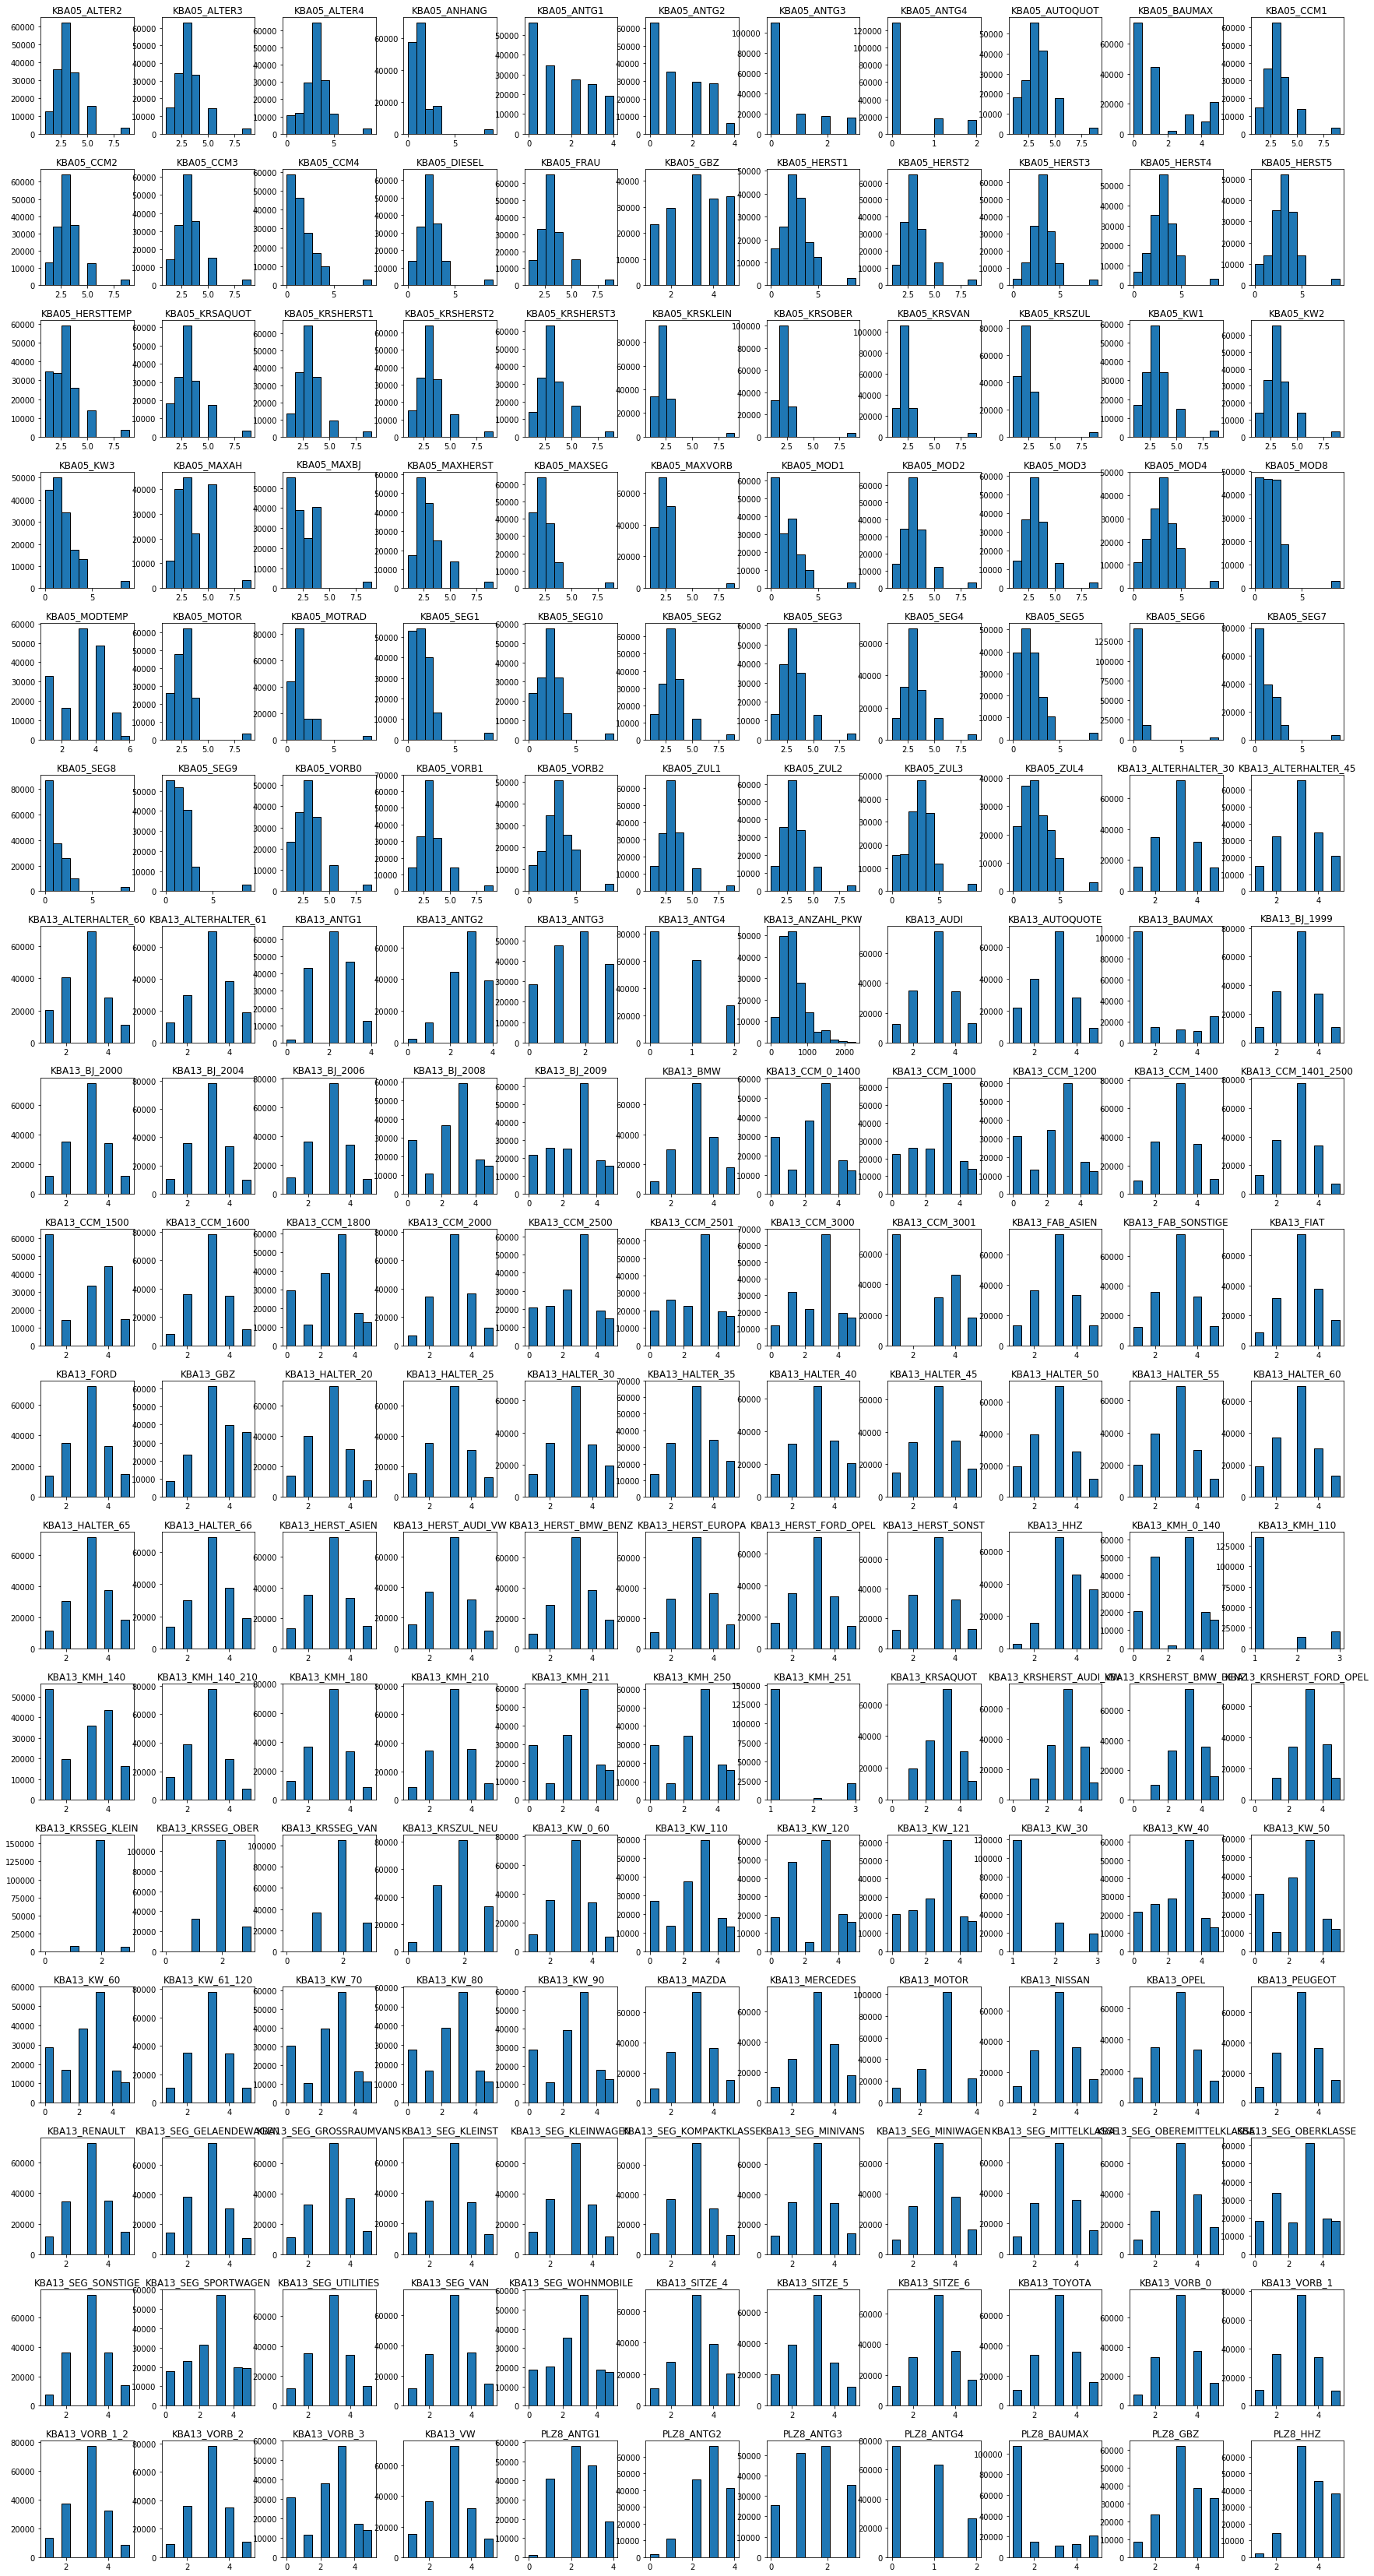

In [62]:
fig, axis = plt.subplots(17, 11, figsize=(30,60))
share_hist_azd=share_azdias.hist(ax=axis, edgecolor='black', grid=False)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

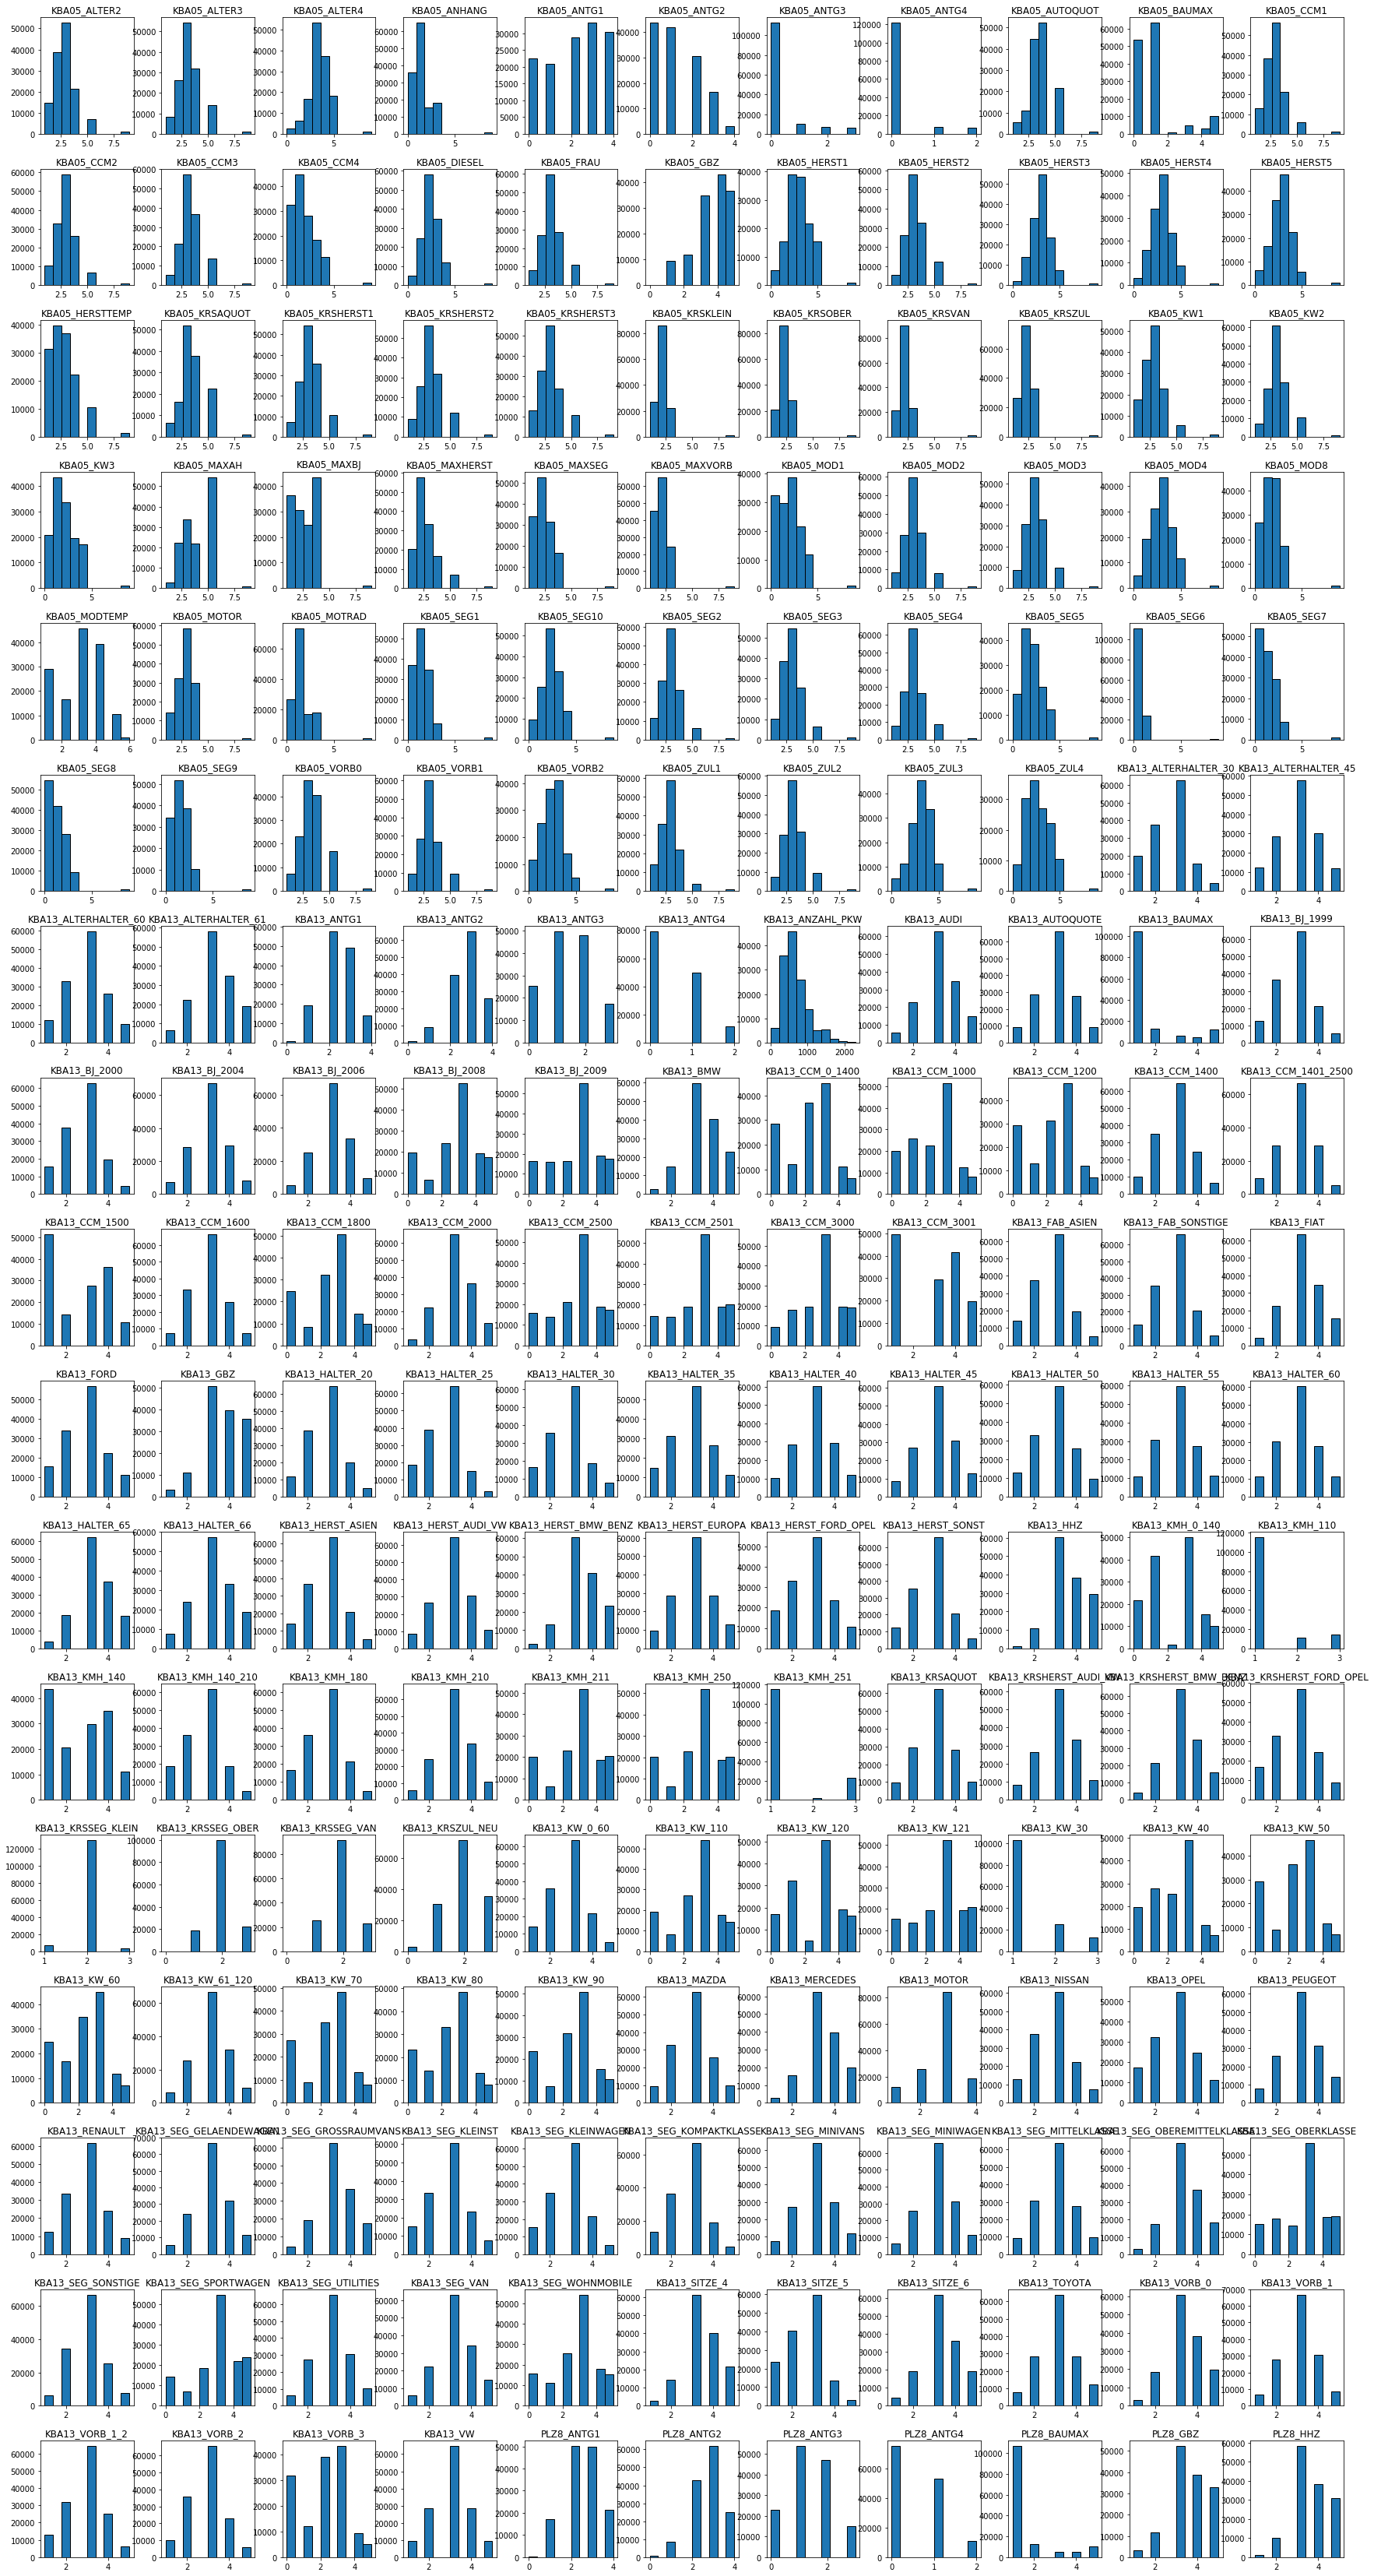

In [63]:
fig, axis = plt.subplots(17, 11, figsize=(30,60))
share_hist_cus=share_customers.hist(ax=axis, edgecolor='black', grid=False)
plt.show

Most of the histograms from the azdias and customer datasets look similar. There are a few columns that can be dropped from this dataframe due to the majority of values being the same.

<function matplotlib.pyplot.show(*args, **kw)>

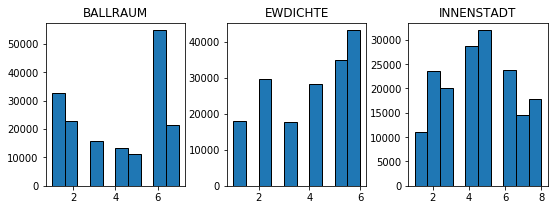

In [64]:
postcode_hist_azd=create_histogram(postcode_azdias)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

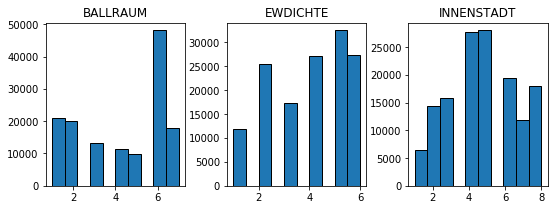

In [65]:
postcode_hist_cus=create_histogram(postcode_customers)
plt.show

These columns all seem reasonable to keep based on the distribution of values.

<function matplotlib.pyplot.show(*args, **kw)>

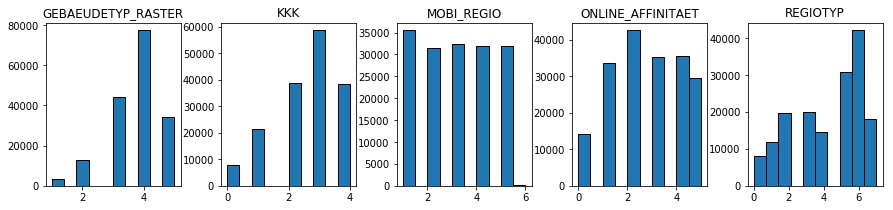

In [66]:
rr1_hist_azd=create_histogram(rr1_azdias)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

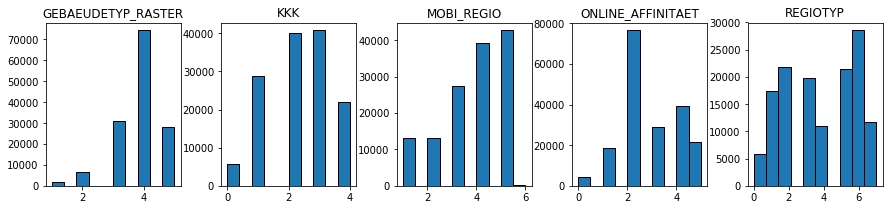

In [67]:
rr1_hist_cus=create_histogram(rr1_customers)
plt.show

All of these columns could be useful

<function matplotlib.pyplot.show(*args, **kw)>

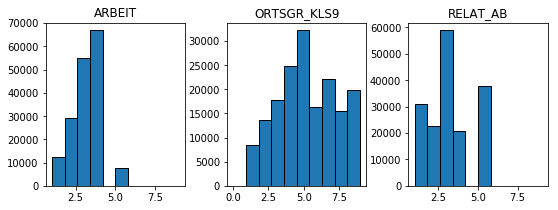

In [68]:
community_hist_azd=create_histogram(community_azdias)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

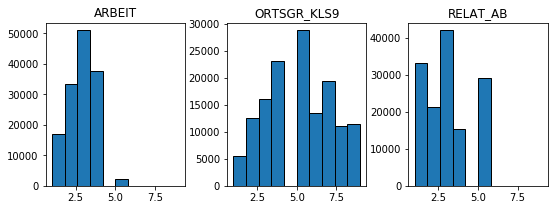

In [69]:
community_hist_cus=create_histogram(community_customers)
plt.show

All of these columns could be useful.

I then decided to have a quick look at the descriptive statistics.

In [70]:
person_azdias.describe()

,LNR,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP
count,1.916520e+05,191652.000000,191652.000000,191652.000000,190635.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,175769.000000,175769.000000,191652.000000,191652.000000
mean,6.374100e+05,-0.364781,2.775979,1.520735,3.636688,3.068457,2.824474,3.398112,3.035288,2.877262,...,3.910395,4.243332,3.946481,3.665383,4.024195,1.267208,0.008119,0.003516,1.197159,3.366993
std,2.575419e+05,1.193594,1.067825,0.499571,1.597500,1.320354,1.463865,1.320942,1.530185,1.485260,...,1.577023,2.007881,1.949282,1.706402,2.079551,1.287698,0.089737,0.080951,0.953003,1.353209
min,1.916540e+05,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,-1.000000,1.000000
25%,4.140185e+05,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,...,3.000000,3.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,3.000000
50%,6.376055e+05,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,3.000000,4.000000,1.000000,0.000000,0.000000,1.000000,3.000000
75%,8.606220e+05,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,...,5.000000,6.000000,6.000000,5.000000,6.000000,2.000000,0.000000,0.000000,2.000000,4.000000
max,1.082865e+06,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,3.000000,1.000000,5.000000,2.000000,6.000000


In [71]:
person_customers.describe()

,LNR,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP
count,191652.000000,191652.000000,191652.000000,191652.000000,188439.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,145056.000000,145056.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,3.060907,1.376432,3.677928,3.963773,2.057051,4.183317,2.439808,2.646176,...,3.165879,4.112788,3.742137,2.919161,4.185279,0.987754,0.009865,0.021681,0.849008,2.576806
std,55325.311233,1.391672,1.086254,0.484492,1.813975,1.036230,1.319422,0.995365,1.697932,1.586506,...,1.316221,2.070958,1.718039,1.219224,2.367407,1.538679,0.098833,0.210424,1.166162,1.168486
min,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,-1.000000,1.000000
25%,47913.750000,-1.000000,3.000000,1.000000,2.000000,3.000000,1.000000,3.000000,1.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,-1.000000,0.000000,0.000000,-1.000000,1.000000
50%,95826.500000,0.000000,3.000000,1.000000,4.000000,4.000000,1.000000,5.000000,2.000000,2.000000,...,3.000000,4.000000,3.000000,3.000000,5.000000,1.000000,0.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,4.000000,2.000000,6.000000,5.000000,4.000000,5.000000,5.000000,5.000000,...,4.000000,7.000000,6.000000,4.000000,6.000000,3.000000,0.000000,0.000000,2.000000,3.000000
max,191652.000000,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,3.000000,1.000000,5.000000,2.000000,6.000000


From these statistics, it appears that the -1 values are skewing some of the columns total values and avergaes. I will change these -1 to 0 to minimise the impact of the unknown values.

In [72]:
household_azdias.describe()

,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,D19_WEIN_FEINKOST,W_KEIT_KIND_HH,WOHNDAUER_2008,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP
count,175769.000000,17283.000000,6337.000000,1307.000000,269.000000,175769.000000,175769.000000,187738.000000,191652.000000,191652.000000,...,191652.000000,168318.000000,175769.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,10.844648,11.687439,13.391352,14.453711,14.962825,1.723899,0.004358,4.207236,0.122555,0.220519,...,0.377231,3.931433,7.901382,3.035288,3.076227,3.068457,2.824474,2.877262,3.398112,3.791054
std,7.650200,4.108960,3.283612,2.702722,2.560921,1.154867,0.070300,1.621893,0.539797,0.751985,...,1.492400,1.964637,1.928101,1.530185,1.354255,1.320354,1.463865,1.485260,1.320942,1.988348
min,0.000000,2.000000,3.000000,6.000000,8.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,8.000000,11.000000,13.000000,13.000000,1.000000,0.000000,3.000000,0.000000,0.000000,...,0.000000,2.000000,8.000000,2.000000,2.000000,2.000000,1.000000,2.000000,3.000000,2.000000
50%,13.000000,12.000000,14.000000,15.000000,15.000000,1.000000,0.000000,5.000000,0.000000,0.000000,...,0.000000,4.000000,9.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000
75%,17.000000,15.000000,16.000000,17.000000,17.000000,2.000000,0.000000,6.000000,0.000000,0.000000,...,0.000000,6.000000,9.000000,5.000000,4.000000,4.000000,4.000000,4.000000,5.000000,6.000000
max,21.000000,18.000000,18.000000,18.000000,18.000000,38.000000,3.000000,6.000000,6.000000,6.000000,...,7.000000,6.000000,9.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000


In [73]:
household_azdias['ANZ_PERSONEN'].value_counts()

1.0     91202
2.0     41902
3.0     20242
4.0     10076
0.0      7451
5.0      3325
6.0      1044
7.0       343
8.0       114
9.0        34
10.0       14
11.0        7
12.0        6
20.0        2
13.0        2
14.0        2
22.0        1
21.0        1
38.0        1
Name: ANZ_PERSONEN, dtype: int64

In [74]:
household_customers.describe()

,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,...,D19_WEIN_FEINKOST,W_KEIT_KIND_HH,WOHNDAUER_2008,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP
count,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,145056.000000,145056.000000,188684.000000,191652.000000,191652.000000,...,191652.000000,137910.000000,145056.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,11.352009,12.337243,13.672353,14.647059,15.377119,2.267828,0.020392,2.942481,0.091040,0.159524,...,0.788126,4.152716,8.646371,2.439808,2.781176,3.963773,2.057051,2.646176,4.183317,4.137958
std,6.275026,4.006050,3.243335,2.753787,2.307653,1.390620,0.152234,1.533347,0.416684,0.589824,...,2.065434,1.974375,1.154001,1.697932,1.147353,1.036230,1.319422,1.586506,0.995365,1.503946
min,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.000000,9.000000,11.000000,13.000000,14.000000,1.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,2.000000,9.000000,1.000000,2.000000,3.000000,1.000000,1.000000,3.000000,2.000000
50%,11.000000,13.000000,14.000000,15.000000,16.000000,2.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,5.000000,9.000000,2.000000,3.000000,4.000000,1.000000,2.000000,5.000000,4.000000
75%,16.000000,16.000000,16.000000,17.000000,17.000000,3.000000,0.000000,4.000000,0.000000,0.000000,...,0.000000,6.000000,9.000000,5.000000,3.000000,5.000000,4.000000,5.000000,5.000000,5.000000
max,21.000000,18.000000,18.000000,18.000000,18.000000,21.000000,5.000000,6.000000,6.000000,6.000000,...,7.000000,6.000000,9.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000


In [75]:
building_azdias.describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KBA05_HERSTTEMP,KBA05_MODTEMP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE
count,171558.000000,170700.000000,171558.000000,171558.000000,171558.000000,175663.000000,171558.00000,171558.000000
mean,8.298307,0.042203,2.798873,2.836598,3.005205,3.015296,1993.28173,4.047856
std,15.450471,0.333381,2.656391,1.493331,1.257176,1.549111,3.34381,1.946679
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1985.00000,0.000000
25%,1.000000,0.000000,1.000000,2.000000,2.000000,2.000000,1992.00000,3.000000
50%,4.000000,0.000000,1.000000,3.000000,3.000000,3.000000,1992.00000,3.000000
75%,9.000000,0.000000,3.000000,4.000000,4.000000,4.000000,1993.00000,5.000000
max,595.000000,18.000000,8.000000,9.000000,6.000000,7.000000,2016.00000,8.000000


In [76]:
building_customers.describe()

,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KBA05_HERSTTEMP,KBA05_MODTEMP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE
count,141725.000000,139542.000000,141725.000000,141725.000000,141725.000000,145001.000000,141725.000000,141725.000000
mean,4.965863,0.067413,2.369942,2.635901,2.912831,3.129978,1993.056659,3.723133
std,14.309694,0.545576,2.434227,1.345303,1.245163,1.439740,3.080241,2.095540
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1985.000000,0.000000
25%,1.000000,0.000000,1.000000,2.000000,2.000000,2.000000,1992.000000,2.000000
50%,1.000000,0.000000,1.000000,2.000000,3.000000,3.000000,1992.000000,3.000000
75%,4.000000,0.000000,3.000000,3.000000,4.000000,4.000000,1992.000000,5.000000
max,523.000000,23.000000,8.000000,9.000000,6.000000,7.000000,2016.000000,8.000000


In [77]:
status_azdias.describe()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015
count,170320,170320,170320
unique,45,19,43
top,6B,8,51
freq,12132,16757,16591


In [78]:
status_customers.describe()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015
count,141224,141224,141224
unique,45,19,43
top,2D,2,14
freq,11208,17574,14708


In [79]:
rr1_azdias.describe()

,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP
count,171555.000000,165481.000000,162976.000000,190635.000000,165481.000000
mean,3.736901,2.590382,2.960154,2.695979,4.254821
std,0.924763,1.121177,1.429729,1.521373,2.035435
min,1.000000,0.000000,1.000000,0.000000,0.000000
25%,3.000000,2.000000,2.000000,1.000000,3.000000
50%,4.000000,3.000000,3.000000,3.000000,5.000000
75%,4.000000,3.000000,4.000000,4.000000,6.000000
max,5.000000,4.000000,6.000000,5.000000,7.000000


In [80]:
rr1_customers.describe()

,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP
count,141725.000000,137392.000000,135672.000000,188439.000000,137392.000000
mean,3.852524,2.321569,3.627425,2.764327,3.814341
std,0.830285,1.100512,1.282444,1.266050,2.075155
min,1.000000,0.000000,1.000000,0.000000,0.000000
25%,3.000000,1.000000,3.000000,2.000000,2.000000
50%,4.000000,2.000000,4.000000,2.000000,4.000000
75%,4.000000,3.000000,5.000000,4.000000,6.000000
max,5.000000,4.000000,6.000000,5.000000,7.000000


In [81]:
community_azdias.describe()

,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,170723.000000,170723.000000,170723.000000
mean,3.168191,5.300147,3.073628
std,1.003049,2.298816,1.364775
min,1.000000,0.000000,1.000000
25%,3.000000,4.000000,2.000000
50%,3.000000,5.000000,3.000000
75%,4.000000,7.000000,4.000000
max,9.000000,9.000000,9.000000


In [82]:
community_customers.describe()

,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,141176.000000,141176.000000,141176.000000
mean,2.824850,5.119517,2.898510
std,1.012415,2.159184,1.422683
min,1.000000,1.000000,1.000000
25%,2.000000,4.000000,2.000000
50%,3.000000,5.000000,3.000000
75%,4.000000,7.000000,4.000000
max,9.000000,9.000000,9.000000


I now decided to look into the excel files as I could use these to help me clean the data in the dataframes.

In [83]:
attributes_values.head()

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,NaN,NaN,0,no classification possible
NaN,NaN,NaN,1,passive elderly
NaN,NaN,NaN,2,cultural elderly
NaN,NaN,NaN,3,experience-driven elderly


In [84]:
attributes_info.head()

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


I want to fill in the Attribute and Description columns so each row is complete.

In [85]:
attributes_values['Attribute'] = attributes_values['Attribute'].ffill()
attributes_values['Description'] = attributes_values['Description'].ffill()
attributes_values

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,AGER_TYP,best-ager typology,0,no classification possible
NaN,AGER_TYP,best-ager typology,1,passive elderly
NaN,AGER_TYP,best-ager typology,2,cultural elderly
NaN,AGER_TYP,best-ager typology,3,experience-driven elderly
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


As I found earlier that some of the columns in the dataframe were not in the Excel files and vice versa, I wanted to look at what is common in all the datasets.

In [86]:
unique_customers = set(list(customers.columns))
unique_azdias = set(list(azdias.columns))
unique_attributes_info = set(list(attributes_info.Attribute))
unique_attributes_values = set(list(attributes_values.Attribute))

common_all = unique_customers & unique_azdias & unique_attributes_info & unique_attributes_values
print(len(common_all))

260


As expected, there are quite a few columns that are not common between all the files.

In [87]:
# deleting the dataframes to clear space
del person_azdias
del person_customers
del household_azdias
del household_customers
del building_azdias
del building_customers
del status_azdias
del status_customers
del rr1_azdias
del rr1_customers
del community_azdias
del community_customers

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Clean

Now that I have explored the data sets, I need to clean the data. To do this, I am going to create functions which will: 

- change the object columns in status to integers
- drop the columns that I found were not needed
- remove any duplicate rows
- change the columns to integers
- fill missing values with 0
- change the -1 to 0
- identify columns that use 9 as 'unknown' and change them to 0

In [34]:
# create function to change object type columns to floats
def change_object_types(df):
    '''This function changes object type columns to floats.
    Arguments:
        df= dataframe containing object type columns
    Output: 
        df= transformed dataframe
    '''
    
    cols_int = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
    cols = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']
    if set(cols_int).issubset(df.columns):
        df[cols_int] = df[cols_int].replace({'X': 0, 'XX': 0})
        df[cols] = df[cols].astype(float)

    return df

In [35]:
# creating a dictionary that stores the encoding values of the unknowns for each column of the dataset
unknown_values = {}
for i, row in attributes_values.iterrows():
    if "unknown" in str(row['Meaning']):
        unknown_values[row['Attribute']] = [int(num) for num in str(row['Value']).split(', ')]
        
# create function to convert unknown values to 0
def unknown_to_zero(df, dictionary):
    ''' This function changes unknown vlaues to 0
    Arguments:
        df= dataframe containing unknown values
    Output:
        none'''
    for key, value in dictionary.items():
        if key in df.columns:
            for i in range(0, len(value)):
                df.loc[df[key] == value[i], key] = 0

In [36]:

# create function to drop unwanted columns
def drop_columns(df):
    ''' This function drops identofied columns
    Arguments: 
        df= dataframe to drop columns from
    Output:
        df= cleaned dataframe'''
    
    cols_to_drop= [ 'AGER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL', 
                  'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
                  'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
                  'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 
                  'D19_BANKEN_ONLINE_QUOTE_12', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
                  'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
                  'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
                  'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
                  'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
                  'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D19_HAUS_DEKO',
                  'D19_KINDERARTIKEL', 'D19_KOSMETIK',
                  'D19_LEBENSMITTEL', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO',
                  'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL',
                  'D19_SCHUHE', 'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK',
                  'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_MOBILE',
                  'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
                  'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
                  'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
                  'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
                  'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSAND_REST', 'D19_VERSI_ANZ_12',
                  'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
                  'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'D19_VERSICHERUNGEN',
                  'D19_VOLLSORTIMENT', 'D19_WEIN_FEINKOST', 'WOHNDAUER_2008', 'KBA05_ANTG3', 
                  'KBA05_ANTG4', 'KBA05_SEG6', 'KBA13_BAUMAX', 'KBA13_KMH_110', 'KBA13_KMH_251', 
                  'KBA13_KRSSEG_KLEIN', 'KBA13_KW_30', 'PLZ8_BAUMAX', 'ANZ_HAUSHALTE_AKTIV', 
                  'ANZ_HH_TITEL', 'MIN_GEBAEUDEJAHR']
    df.drop(columns=cols_to_drop, inplace=True)
    
    return df

In [37]:
# full function to clean data
def clean_data(df):
    '''
    Cleans the input dataframe by doing the following:
    - drop the columns that I found were not needed
    - remove any duplicate rows
    - change the object columns to float
    - fill missing values with 0
    - identify 'unknown' and change them to 0
    Arguments: 
        df= input dataframe from load function
        
    Output: 
        df= cleaned dataframe    
    '''
    # drop columns that are not needed
    drop_columns(df)
    # remove duplicate rows
    df.drop_duplicates(inplace=True)
    
    # fill missing values with 0
    df.replace(np.nan, 0, inplace=True)
    # change unknown values to 0
    unknown_to_zero(df, unknown_values)
    # change object columns to float
    change_object_types(df)
    # setting index as LNR
    #df = df.set_index(['LNR'])
    return df


Using the clean_data function to clean the azdias and customer dataframes

In [92]:
# clean data from azdias
azdias=clean_data(azdias)

In [93]:
# clean data from customer dataset
customers=clean_data(customers)

Change the categorical variables to numeric so they can be used in the analysis.

In [94]:
# changing categorical variables to numeric
customers['CAMEO_DEU_2015']=customers['CAMEO_DEU_2015'].astype('category')
customers['CAMEO_DEU_2015_cat'] = customers['CAMEO_DEU_2015'].cat.codes
customers['CAMEO_DEU_2015_cat'].astype(int)

azdias['CAMEO_DEU_2015']=azdias['CAMEO_DEU_2015'].astype('category')
azdias['CAMEO_DEU_2015_cat'] = azdias['CAMEO_DEU_2015'].cat.codes
azdias['CAMEO_DEU_2015_cat'].astype(int)

886199    43
47902      0
578241    31
283894     0
862418    38
604859    32
773934     0
83864     38
655334    16
325080    31
166487    14
598365     4
421707    15
691086    22
671644    36
777570    29
857193     0
890365    26
691790    22
355543    31
725457    37
739811     8
509603     0
381581    36
45884     41
288048    16
452312    33
553906     9
628586    13
76800     29
          ..
507395     7
151290    14
95041     25
268868    19
489475    40
302476    13
253711    36
598262     0
123885    12
288123     0
879375    26
654543     5
18194      0
558036    15
272130     0
281785     0
616400     0
510955    31
622832    36
739942     0
79912     12
672927     0
272926     9
141826    16
520491    26
694849     9
63252     12
27084     27
878574    13
152303    37
Name: CAMEO_DEU_2015_cat, Length: 191652, dtype: int64

In [95]:
# changing categorical variables to numeric
customers['EINGEFUEGT_AM']=customers['EINGEFUEGT_AM'].astype('category')
customers['EINGEFUEGT_AM_cat'] = customers['EINGEFUEGT_AM'].cat.codes
customers['EINGEFUEGT_AM_cat'].astype(int)

azdias['EINGEFUEGT_AM']=azdias['EINGEFUEGT_AM'].astype('category')
azdias['EINGEFUEGT_AM_cat'] = azdias['EINGEFUEGT_AM'].cat.codes
azdias['EINGEFUEGT_AM_cat'].astype(int)

886199     169
47902        0
578241    3171
283894       0
862418      43
604859    2411
773934       0
83864        1
655334       1
325080       2
166487       2
598365       1
421707       1
691086       2
671644       2
777570       1
857193       0
890365       1
691790       1
355543       2
725457       1
739811       1
509603       0
381581    2203
45884        1
288048       2
452312       2
553906    1173
628586       1
76800      172
          ... 
507395       2
151290       1
95041        2
268868       2
489475       1
302476       2
253711       2
598262       0
123885       1
288123       0
879375       1
654543       1
18194        0
558036       1
272130       0
281785       0
616400       0
510955       1
622832       1
739942       0
79912        1
672927       0
272926       1
141826       2
520491       1
694849     118
63252        1
27084        2
878574     699
152303       1
Name: EINGEFUEGT_AM_cat, Length: 191652, dtype: int64

In [96]:
# changing categorical variables to numeric
customers['OST_WEST_KZ']=customers['OST_WEST_KZ'].astype('category')
customers['OST_WEST_KZ_cat'] = customers['OST_WEST_KZ'].cat.codes
customers['OST_WEST_KZ_cat'].astype(int)

azdias['OST_WEST_KZ']=azdias['OST_WEST_KZ'].astype('category')
azdias['OST_WEST_KZ_cat'] = azdias['OST_WEST_KZ'].cat.codes
azdias['OST_WEST_KZ_cat'].astype(int)

886199    1
47902     0
578241    1
283894    0
862418    1
604859    2
773934    0
83864     1
655334    2
325080    2
166487    2
598365    2
421707    2
691086    2
671644    2
777570    1
857193    0
890365    1
691790    2
355543    2
725457    2
739811    2
509603    0
381581    2
45884     2
288048    2
452312    2
553906    2
628586    2
76800     1
         ..
507395    2
151290    2
95041     2
268868    2
489475    1
302476    2
253711    2
598262    0
123885    2
288123    0
879375    2
654543    2
18194     0
558036    1
272130    0
281785    0
616400    0
510955    1
622832    2
739942    0
79912     2
672927    0
272926    1
141826    2
520491    2
694849    2
63252     2
27084     2
878574    1
152303    1
Name: OST_WEST_KZ_cat, Length: 191652, dtype: int64

In [97]:
# changing categorical variables to numeric
customers['PRODUCT_GROUP']=customers['PRODUCT_GROUP'].astype('category')
customers['PRODUCT_GROUP_cat'] = customers['PRODUCT_GROUP'].cat.codes
customers['PRODUCT_GROUP_cat'].astype(int)

0         1
1         2
2         1
3         0
4         2
5         1
6         1
7         2
8         0
9         0
10        0
11        2
12        2
13        2
14        1
15        1
16        0
17        0
18        0
19        2
20        2
21        2
22        2
23        0
24        1
25        1
26        0
27        0
28        0
29        2
         ..
191622    1
191623    1
191624    0
191625    2
191626    1
191627    1
191628    0
191629    0
191630    0
191631    1
191632    2
191633    2
191634    1
191635    1
191636    1
191637    2
191638    1
191639    1
191640    0
191641    1
191642    2
191643    1
191644    1
191645    1
191646    2
191647    1
191648    0
191649    1
191650    2
191651    1
Name: PRODUCT_GROUP_cat, Length: 191652, dtype: int64

In [98]:
# changing categorical variables to numeric
customers['CUSTOMER_GROUP']=customers['CUSTOMER_GROUP'].astype('category')
customers['CUSTOMER_GROUP_cat'] = customers['CUSTOMER_GROUP'].cat.codes
customers['CUSTOMER_GROUP_cat'].astype(int)

0         0
1         1
2         0
3         0
4         0
5         0
6         0
7         1
8         0
9         0
10        0
11        1
12        1
13        1
14        0
15        0
16        1
17        0
18        1
19        1
20        1
21        1
22        1
23        1
24        0
25        0
26        0
27        1
28        0
29        1
         ..
191622    0
191623    0
191624    0
191625    1
191626    0
191627    0
191628    1
191629    0
191630    1
191631    0
191632    1
191633    1
191634    0
191635    0
191636    0
191637    1
191638    0
191639    0
191640    1
191641    0
191642    1
191643    0
191644    0
191645    0
191646    1
191647    0
191648    1
191649    0
191650    1
191651    0
Name: CUSTOMER_GROUP_cat, Length: 191652, dtype: int64

In [99]:
# dropping the old category columns 
cols_to_drop=['CAMEO_DEU_2015','OST_WEST_KZ', 'EINGEFUEGT_AM', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']
customers.drop(columns=cols_to_drop, inplace=True)

In [100]:
cols_to_drop=['CAMEO_DEU_2015','OST_WEST_KZ', 'EINGEFUEGT_AM']
azdias.drop(columns= cols_to_drop, inplace=True)

In [101]:
# checking the type of the new columns
customers.dtypes

LNR                             int64
AKT_DAT_KL                    float64
ALTER_HH                      float64
ALTER_KIND1                   float64
ALTER_KIND2                   float64
ALTER_KIND3                   float64
ALTER_KIND4                   float64
ALTERSKATEGORIE_FEIN          float64
ANZ_KINDER                    float64
ANZ_STATISTISCHE_HAUSHALTE    float64
ARBEIT                        float64
BALLRAUM                      float64
CAMEO_DEUG_2015               float64
CAMEO_INTL_2015               float64
CJT_GESAMTTYP                 float64
CJT_KATALOGNUTZER             float64
CJT_TYP_1                     float64
CJT_TYP_2                     float64
CJT_TYP_3                     float64
CJT_TYP_4                     float64
CJT_TYP_5                     float64
CJT_TYP_6                     float64
D19_KONSUMTYP                 float64
D19_KONSUMTYP_MAX               int64
DSL_FLAG                      float64
EINGEZOGENAM_HH_JAHR          float64
EWDICHTE    

Now that the data is clean, I am going to move on to the analysis section.

In [102]:
customers.to_pickle('customers.pkl')

del customers

In [103]:
azdias.to_pickle('azdias.pkl')

del azdias

# Analyse

In [104]:
customers = pd.read_pickle('customers.pkl')

In [105]:
azdias= pd.read_pickle('azdias.pkl')

I decided to use PCA and k-means clustering to put my customers into clusters. I chose to use these together as it is believed to improve the clustering results.

First I need to strandardised the data in the data set otherwise, the weights of different columns will be treated differently.

In [106]:
scaled_customers = StandardScaler().fit_transform(customers)

I then initiated a pca instance and fit my standardised data to it.

In [107]:
pca=PCA()
pca.fit(scaled_customers)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Looking at the explained variance ratio

In [108]:
pca.explained_variance_ratio_

array([  4.97468840e-01,   3.85446152e-02,   2.85579334e-02,
         2.41873466e-02,   1.86834538e-02,   1.60949353e-02,
         1.30971959e-02,   9.85206712e-03,   9.44933352e-03,
         9.15718426e-03,   8.76618834e-03,   7.97063692e-03,
         7.46041361e-03,   6.20551102e-03,   6.01701639e-03,
         5.83676512e-03,   5.64925273e-03,   5.45295997e-03,
         5.13717908e-03,   4.86019258e-03,   4.61265670e-03,
         4.40177452e-03,   4.24729146e-03,   4.02755414e-03,
         3.94319737e-03,   3.84087682e-03,   3.77770613e-03,
         3.73068905e-03,   3.66651730e-03,   3.51214528e-03,
         3.50882670e-03,   3.42730494e-03,   3.36724655e-03,
         3.35502777e-03,   3.26110817e-03,   3.15433577e-03,
         3.13394959e-03,   3.10046904e-03,   3.06227733e-03,
         3.01251264e-03,   2.94878601e-03,   2.89339168e-03,
         2.86785936e-03,   2.84948387e-03,   2.79365377e-03,
         2.75756726e-03,   2.72475434e-03,   2.69048952e-03,
         2.66825750e-03,

Looking at how many columns are in the data to decide how many components to include

In [109]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Columns: 285 entries, LNR to CUSTOMER_GROUP_cat
dtypes: float64(245), int16(1), int64(35), int8(4)
memory usage: 412.0 MB


I then plotted the explained variance to allow me to see how many components to keep.

Text(0,0.5,'Cumulative explained variance')

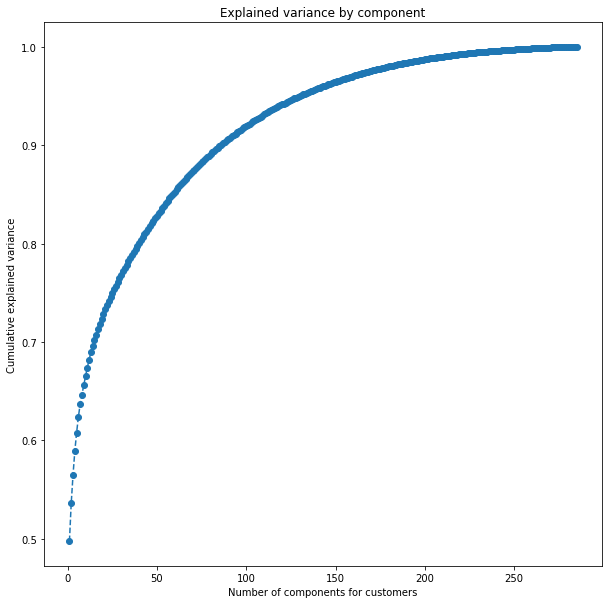

In [110]:
plt.figure(figsize=(10,10))
plt.plot(range(1,286), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained variance by component')
plt.xlabel('Number of components for customers')
plt.ylabel('Cumulative explained variance')

Although 80% variance is the rule of thumb, by keeping around 100 components, I can preserve around 90% of the variance. I can also try with 50 components to see if it changes the output.
I preformed PCA using 100 components.

In [111]:
pca = PCA(n_components=100)

pca.fit(scaled_customers)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Applying the standardised data to the pca

In [112]:
customers_pca=pca.transform(scaled_customers)

I then started the k-means clustering. To decide how many clusters to use, I decided to create an elbow plot.

In [113]:
# generating values from tests of different number of clusters
wcss = []
for k in range(1, 21):
    kmeans_pca = KMeans(n_clusters=k, init= 'k-means++', random_state= 42)
    kmeans_pca.fit(customers_pca)
    wcss.append(kmeans_pca.inertia_)

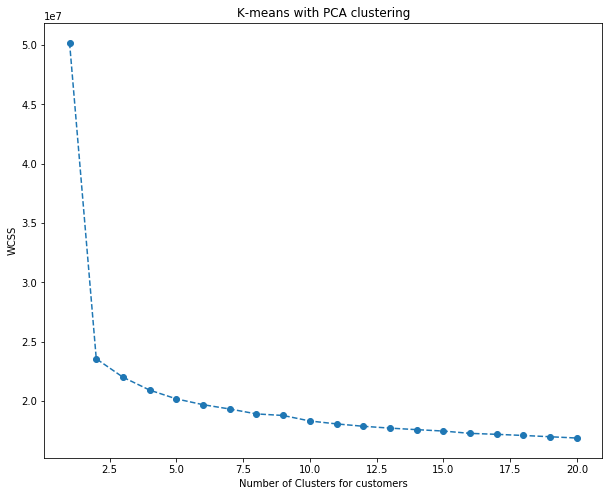

In [114]:
# plotting the graph
plt.figure(figsize = (10, 8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters for customers")
plt.ylabel("WCSS")
plt.title('K-means with PCA clustering')
plt.show()

From the plot, I can see there is a clear elbow at 2. Therefore, I will use 2 clusters.

In [115]:
# initiating the k-means with 2 clusters
kmeans_pca= KMeans(n_clusters= 2, init= 'k-means++', random_state= 42)
# fitting the k-means cluster with the pca results
kmeans_pca.fit(customers_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [116]:
# changing the pca results to a dataframe so I can combine it with the original dataframe
customers_pca=pd.DataFrame(customers_pca)

In [117]:
# combining the customer dataframe with the results of the pca
final_customers=pd.concat([customers.reset_index(drop=True), customers_pca], axis= 1)

In [118]:
# creating a new column in the customers dataframe to store the results of the k-means clustering
final_customers['K-means_pca']=kmeans_pca.labels_

In [119]:
final_customers.to_pickle("final_customers.pkl")
del final_customers

Now I have the results of the pca and k-means clustering for the customer dataset, I will repeat the process for the azdias dataset.

In [120]:
scaled_azdias = StandardScaler().fit_transform(azdias)

In [121]:
pca=PCA()
pca.fit(scaled_azdias)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [122]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 886199 to 152303
Columns: 282 entries, LNR to OST_WEST_KZ_cat
dtypes: float64(245), int16(1), int64(34), int8(2)
memory usage: 410.1 MB


Text(0,0.5,'Cumulative explained variance')

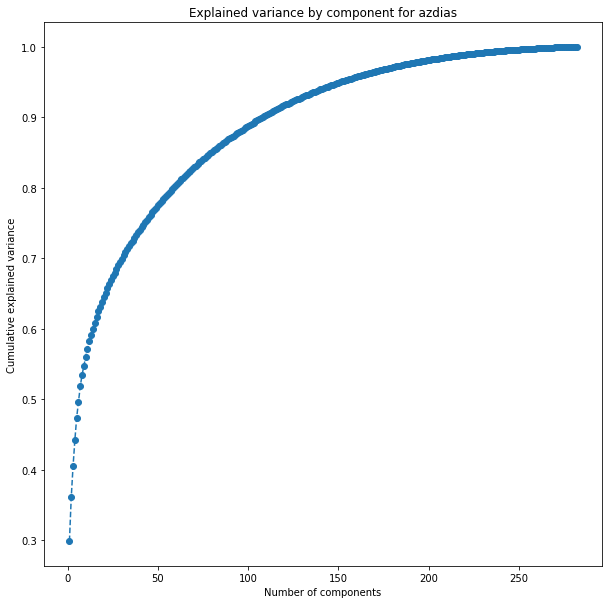

In [123]:
plt.figure(figsize=(10,10))
plt.plot(range(1,283), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained variance by component for azdias')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [124]:
pca = PCA(n_components=100)

pca.fit(scaled_azdias)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [125]:
azdias_pca=pca.transform(scaled_azdias)

In [126]:
# generating values from tests of different number of clusters
wcss = []
for k in range(1, 21):
    kmeans_pca = KMeans(n_clusters=k, init= 'k-means++', random_state= 42)
    kmeans_pca.fit(azdias_pca)
    wcss.append(kmeans_pca.inertia_)

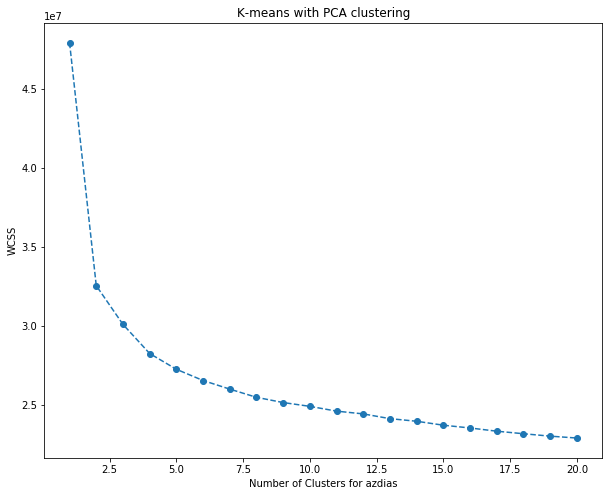

In [127]:
# plotting the graph
plt.figure(figsize = (10, 8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters for azdias")
plt.ylabel("WCSS")
plt.title('K-means with PCA clustering')
plt.show()

In [128]:
# initiating the k-means with 2 clusters
kmeans_pca= KMeans(n_clusters= 2, init= 'k-means++', random_state= 42)
# fitting the k-means cluster with the pca results
kmeans_pca.fit(azdias_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [129]:
# changing the pca results to a dataframe so I can combine it with the original dataframe
azdias_pca=pd.DataFrame(azdias_pca)

In [130]:
# combining the customer dataframe with the results of the pca
final_azdias=pd.concat([azdias.reset_index(drop=True), azdias_pca], axis= 1)

In [131]:
# creating a new column in the customers dataframe to store the results of the k-means clustering
final_azdias['K-means_pca']=kmeans_pca.labels_

In [132]:
final_azdias.to_pickle("final_azdias.pkl")
del final_azdias

Now I can look at comparing the two datasets 

In [4]:
final_customers = pd.read_pickle('final_customers.pkl')

In [5]:
final_azdias = pd.read_pickle('final_azdias.pkl')

In [6]:
# group the customers by clusters and see the average values for each variable.
customer_pca_kmeans_freq = final_customers.groupby(['K-means_pca']).mean()
customer_pca_kmeans_freq

,LNR,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,...,90,91,92,93,94,95,96,97,98,99
K-means_pca,,,,,,,,,,,,,,,,,,,,,
0,95991.651799,1.731140,11.367692,0.999017,0.480448,0.128921,0.025516,9.955284,0.136093,4.618976,...,0.000032,0.000506,0.000171,0.001397,0.000838,0.001136,0.000965,-0.000316,0.000933,0.000589
1,95373.853259,0.203072,0.984463,0.095232,0.044210,0.011165,0.000898,0.908536,0.013195,0.345441,...,-0.000087,-0.001386,-0.000469,-0.003828,-0.002296,-0.003113,-0.002646,0.000865,-0.002556,-0.001615


In [7]:
# group the azdias by clusters and see the average values for each variable.
azdias_pca_kmeans_freq = final_azdias.groupby(['K-means_pca']).mean()
azdias_pca_kmeans_freq

,LNR,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,...,90,91,92,93,94,95,96,97,98,99
K-means_pca,,,,,,,,,,,,,,,,,,,,,
0,637362.422681,4.415975,10.885741,1.154330,0.487758,0.109105,0.023388,10.553208,0.153974,7.603889,...,0.000223,-0.000801,-0.000276,-0.000739,-0.000593,0.000048,-0.000740,0.000242,-0.000866,-0.000302
1,637761.145639,1.471314,3.003326,0.312546,0.110586,0.020743,0.003370,2.924292,0.040261,0.961577,...,-0.001644,0.005914,0.002036,0.005461,0.004384,-0.000356,0.005464,-0.001791,0.006395,0.002233


In [8]:
kmeans = KMeans(n_clusters=2)

In [9]:
customers_clusters = kmeans.fit_predict(final_customers)

In [10]:
azdias_clusters= kmeans.fit_predict(final_azdias)

In [11]:
# look at the number of customers in each cluster
print(pd.Series(azdias_clusters).value_counts())
print(pd.Series(customers_clusters).value_counts())

1    95896
0    95756
dtype: int64
0    95833
1    95819
dtype: int64


The numbers are quite similar, which is expected as I used a sample from the azdias dataset which was the same size as the customer dataset. This suggests that around half of the customers should be likely to become customers.

In [12]:
del final_customers
del final_azdias
del azdias_clusters
del customers_clusters

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [13]:
# load data
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
# check head
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


Now the training data is loaded, I want to explore the response column to get an idea of the values in it.

In [15]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

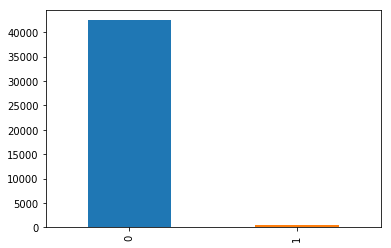

In [16]:
mailout_train.RESPONSE.value_counts().plot(kind='bar')

The vast majority of values are 0. As the proportion of values differ so much, it causes a class imbalance.

I will clean the training dataset in the same way I cleaned the two other datasets

In [39]:
mailout_train=clean_data(mailout_train)
mailout_train.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,1.0,8.0,0.0,0.0,0.0,0.0,8.0,0.0,13.0,...,2.0,5.0,2.0,1.0,6.0,3.0,3,0,2,4
1,1771,4.0,13.0,0.0,0.0,0.0,0.0,13.0,0.0,1.0,...,3.0,1.0,2.0,1.0,4.0,7.0,1,0,2,3
2,1776,1.0,9.0,0.0,0.0,0.0,0.0,7.0,0.0,1.0,...,1.0,6.0,4.0,2.0,0.0,2.0,3,0,1,4
3,1460,1.0,6.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,...,4.0,8.0,11.0,11.0,6.0,1.0,3,0,2,4
4,1783,1.0,9.0,0.0,0.0,0.0,0.0,9.0,0.0,44.0,...,4.0,2.0,2.0,1.0,6.0,3.0,3,0,1,3


In [40]:
mailout_train['CAMEO_DEU_2015']=mailout_train['CAMEO_DEU_2015'].astype('category')
mailout_train['CAMEO_DEU_2015_cat'] = mailout_train['CAMEO_DEU_2015'].cat.codes
mailout_train['CAMEO_DEU_2015_cat'].astype(int)

0        22
1        20
2         9
3         9
4        32
5        32
6        16
7        21
8         0
9         0
10        0
11       13
12       19
13        8
14       14
15       26
16        0
17        1
18        0
19       39
20       15
21       26
22       31
23       18
24       10
25       26
26       33
27        0
28       26
29       21
         ..
42932    39
42933    26
42934    14
42935    31
42936    26
42937    20
42938    14
42939     9
42940     3
42941    14
42942    39
42943    19
42944    32
42945    33
42946    20
42947    26
42948    19
42949    37
42950     1
42951    41
42952    26
42953     8
42954     0
42955    13
42956    36
42957    12
42958    26
42959    14
42960    36
42961    14
Name: CAMEO_DEU_2015_cat, Length: 42962, dtype: int64

In [41]:
mailout_train['EINGEFUEGT_AM']=mailout_train['EINGEFUEGT_AM'].astype('category')
mailout_train['EINGEFUEGT_AM_cat'] = mailout_train['EINGEFUEGT_AM'].cat.codes
mailout_train['EINGEFUEGT_AM_cat'].astype(int)

0           2
1         710
2         321
3           2
4           2
5           2
6           2
7         741
8           0
9           0
10          0
11          2
12        430
13          2
14          3
15          2
16          0
17       1167
18          0
19        282
20          2
21          2
22          3
23          2
24          2
25          2
26          2
27          0
28          2
29          2
         ... 
42932     308
42933       2
42934       2
42935       2
42936       3
42937     761
42938    1205
42939       3
42940       2
42941       2
42942       2
42943     714
42944       2
42945       2
42946       3
42947       2
42948       2
42949       3
42950       2
42951       2
42952       2
42953     613
42954       0
42955       2
42956       3
42957       2
42958       2
42959       2
42960       3
42961       2
Name: EINGEFUEGT_AM_cat, Length: 42962, dtype: int64

In [42]:
mailout_train['OST_WEST_KZ']=mailout_train['OST_WEST_KZ'].astype('category')
mailout_train['OST_WEST_KZ_cat'] = mailout_train['OST_WEST_KZ'].cat.codes
mailout_train['OST_WEST_KZ_cat'].astype(int)

0        2
1        2
2        1
3        2
4        2
5        2
6        2
7        2
8        0
9        0
10       0
11       1
12       2
13       2
14       2
15       2
16       0
17       1
18       0
19       1
20       2
21       1
22       2
23       2
24       2
25       1
26       2
27       0
28       2
29       2
        ..
42932    2
42933    1
42934    2
42935    2
42936    2
42937    2
42938    2
42939    2
42940    2
42941    2
42942    1
42943    1
42944    2
42945    1
42946    2
42947    2
42948    2
42949    2
42950    2
42951    2
42952    2
42953    2
42954    0
42955    1
42956    2
42957    2
42958    1
42959    2
42960    2
42961    2
Name: OST_WEST_KZ_cat, Length: 42962, dtype: int64

In [43]:
mailout_train.dtypes

LNR                              int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_KINDER                     float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                category
CAMEO_DEUG_2015                float64
CAMEO_INTL_2015                float64
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                      float64
CJT_TYP_5                      float64
CJT_TYP_6                      float64
D19_KONSUMTYP                  float64
D19_KONSUMTYP_MAX                int64
DSL_FLAG                 

In [44]:
cols_to_drop=['CAMEO_DEU_2015','OST_WEST_KZ', 'EINGEFUEGT_AM']
mailout_train.drop(columns= cols_to_drop, inplace=True)

In [45]:
mailout_train.drop(columns= 'LNR', inplace=True)

### Model

The three classifiers I will test are K-nearest neighbors (k-nn) and random forest classifier and random forest regressor. I chose these as they were suggested in this article:https://builtin.com/data-science/supervised-machine-learning-classification as being good classifiers for my problem and solution


First, I split the mailout_train dataset into train and test datasets, then scaling the values.

In [46]:
# Split the data into features (X) and target (y)
X = mailout_train.drop('RESPONSE', axis=1)
y = mailout_train['RESPONSE']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

I started by calculating a baseline error

In [47]:
# create a list of column names to use as features
feature_list = list(mailout_train.columns)

In [48]:
# The baseline predictions are the historical averages
baseline_preds = X_test[:, feature_list.index('RESPONSE')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)
print('Average baseline accuracy: ', round(np.mean(baseline_errors), 4))

Average baseline accuracy:  0.9806


The baseline accuracy is 98.37%. This is very high but considering the number of 0's in the response column, it is not surprising. This implies that I could accurate predict 98.37% of responses by just entering the same number in all. However, I want to see if there is a model that can do better than the baseline.

I then fit the training data to the RandomForestClassifier.

In [49]:
# initiate the random forest classifier
clf=RandomForestClassifier()
# fit the training data to the classifier
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
# Use the predict method on the test data
predictions = clf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.01 degrees.


The MAE is 0.01 

In [51]:
# Calculate accuracy
print (clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.995461025925
0.988944489701


The accuracy is 99.5% for the training data and 98.86% for the testing data. This is better than the baseline average.

In [52]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(mailout_train, round(importance, 2)) for mailout_train, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: CAMEO_INTL_2015      Importance: 0.01
Variable: CJT_GESAMTTYP        Importance: 0.01
Variable: CJT_TYP_6            Importance: 0.01
Variable: EINGEZOGENAM_HH_JAHR Importance: 0.01
Variable: EXTSEL992            Importance: 0.01
Variable: GEBAEUDETYP_RASTER   Importance: 0.01
Variable: GEBURTSJAHR          Importance: 0.01
Variable: GEMEINDETYP          Importance: 0.01
Variable: GFK_URLAUBERTYP      Importance: 0.01
Variable: KBA05_HERST4         Importance: 0.01
Variable: KBA05_HERST5         Importance: 0.01
Variable: KBA05_MODTEMP        Importance: 0.01
Variable: KBA13_ALTERHALTER_30 Importance: 0.01
Variable: KBA13_ANZAHL_PKW     Importance: 0.01
Variable: KBA13_CCM_2501       Importance: 0.01
Variable: KBA13_CCM_3000       Importance: 0.01
Variable: KBA13_HALTER_20      Importance: 0.01
Variable: KBA13_KW_40          Importance: 0.01
Variable: KBA13_KW_50          Importance: 0.01
Variable: KBA13_KW_90          Importance: 0.01
Variable: KBA13_SEG_UTILITIES  Importanc

I then did the same for the RandomForestRegressor

In [53]:
# Instantiate model with 100 estimators
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [54]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.03 degrees.


The MAE is 0.03

In [55]:
# Calculate accuracy
print (rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.741649711363
-0.062134975064


The accuracy is 75.82% for the training data and -5.15% for testing data. This model is a lot worse than the baseline for accuracy so I will not be using this.

I then did the same for K-Nearest Neighbors

In [56]:
# Instantiate model with 3 neighbours
knn = KNeighborsClassifier(n_neighbors=3)
# Train the model on training data
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [57]:
# Use the forest's predict method on the test data
predictions = knn.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.01 degrees.


The MAE for this model is 0.01

In [58]:
print (knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.987459629317
0.98847899453


The accuracy is 98.76% for the training data and 98.78 for the testing.

As the randomm forest classifier had the best accuracy, I will chose this as my classifier model. Now, I want to find the best model and parameters.

In [59]:
param_grid = {'n_estimators': [5, 10, 15, 20],'max_depth': [2, 5, 7, 9]}

In [60]:
grid_clf = GridSearchCV(clf, param_grid, cv=10)
grid_clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15, 20], 'max_depth': [2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [61]:
best_model= grid_clf.best_estimator_
best_parameters= grid_clf.best_params_

In [62]:
best_parameters

{'max_depth': 2, 'n_estimators': 5}

### Apply to test data

Now I have the best model, I will apply it to the test data.

In [63]:
# load the data
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
# clean the data
mailout_test= clean_data(mailout_test)

In [65]:
mailout_test['CAMEO_DEU_2015']=mailout_test['CAMEO_DEU_2015'].astype('category')
mailout_test['CAMEO_DEU_2015_cat'] = mailout_test['CAMEO_DEU_2015'].cat.codes
mailout_test['CAMEO_DEU_2015_cat'].astype(int)

0         7
1        19
2        31
3         7
4        19
5        43
6        18
7        26
8         9
9        26
10        4
11       35
12       16
13        0
14        3
15       14
16       24
17       28
18       12
19       41
20       19
21       14
22       27
23       14
24       37
25        9
26       16
27       16
28        9
29        0
         ..
42803    14
42804    14
42805    43
42806    17
42807    31
42808    28
42809     8
42810     0
42811    40
42812    25
42813    13
42814    13
42815    26
42816    26
42817    13
42818    43
42819    13
42820     3
42821     4
42822    39
42823    14
42824    36
42825    33
42826    14
42827    26
42828     0
42829    25
42830    16
42831     2
42832    36
Name: CAMEO_DEU_2015_cat, Length: 42833, dtype: int64

In [66]:
mailout_test['EINGEFUEGT_AM']=mailout_test['EINGEFUEGT_AM'].astype('category')
mailout_test['EINGEFUEGT_AM_cat'] = mailout_test['EINGEFUEGT_AM'].cat.codes
mailout_test['EINGEFUEGT_AM_cat'].astype(int)

0          91
1           1
2           1
3           1
4           1
5           1
6           1
7           2
8         831
9           2
10          1
11          1
12          1
13          0
14        423
15          1
16        503
17         80
18        780
19          1
20       1324
21          2
22          1
23          1
24          1
25          2
26          2
27        382
28          1
29          0
         ... 
42803     448
42804       2
42805       2
42806       1
42807     139
42808       1
42809       1
42810       0
42811       2
42812       1
42813       2
42814       1
42815       2
42816       1
42817       2
42818       1
42819       2
42820     488
42821     410
42822       1
42823     457
42824      25
42825       1
42826       1
42827       1
42828       0
42829       1
42830       2
42831       1
42832       1
Name: EINGEFUEGT_AM_cat, Length: 42833, dtype: int64

In [67]:
mailout_test['OST_WEST_KZ']=mailout_test['OST_WEST_KZ'].astype('category')
mailout_test['OST_WEST_KZ_cat'] = mailout_test['OST_WEST_KZ'].cat.codes
mailout_test['OST_WEST_KZ_cat'].astype(int)

0        2
1        2
2        2
3        1
4        2
5        1
6        2
7        2
8        2
9        2
10       2
11       1
12       2
13       0
14       1
15       2
16       2
17       1
18       2
19       2
20       2
21       2
22       2
23       2
24       2
25       2
26       2
27       2
28       2
29       0
        ..
42803    1
42804    2
42805    2
42806    2
42807    1
42808    2
42809    1
42810    0
42811    2
42812    2
42813    2
42814    2
42815    2
42816    2
42817    2
42818    2
42819    2
42820    2
42821    2
42822    1
42823    2
42824    1
42825    1
42826    2
42827    1
42828    0
42829    2
42830    2
42831    2
42832    2
Name: OST_WEST_KZ_cat, Length: 42833, dtype: int64

In [68]:
cols_to_drop=['CAMEO_DEU_2015','OST_WEST_KZ', 'EINGEFUEGT_AM']
mailout_test.drop(columns= cols_to_drop, inplace=True)

In [69]:
LNR_test = mailout_test['LNR']
mailout_test.drop(columns= 'LNR', inplace=True)

Now I will standardised the values, fit the model and generate predictions.

In [70]:
# scale features
scaler = StandardScaler()
mailout_test = pd.DataFrame(scaler.fit_transform(mailout_test))

In [71]:
# generate predications on the test dataset using the best model found
predictions = best_model.predict(mailout_test)

In [72]:
# Getting values of LNR
values=LNR_test.values
values

array([ 1754,  1770,  1465, ..., 67942, 67949, 68898])

In [73]:
# Create dataframe of LNR values and RESPONSE predictions
final_predictions= pd.DataFrame({'LNR':values, 'RESPONSE':predictions})
final_predictions.head()

,LNR,RESPONSE
0,1754,0
1,1770,0
2,1465,0
3,1470,0
4,1478,0


In [74]:
# Finding people who are likely to become customers
final_predictions.loc[final_predictions['RESPONSE'] == 1]

,LNR,RESPONSE


In [75]:
# Checking the dataframe to make sure the previous output was accurate
final_predictions['RESPONSE'].value_counts()

0    42833
Name: RESPONSE, dtype: int64

There are no people in the data set who are likely to become customers!